## Import packages

In [1]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.transforms import v2
from rasterio.plot import show

import os
import pandas as pd

from PIL import Image
import rasterio

3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]


## Import the tabular data

In [2]:
# Specify the path to your CSV file
csv_file_path = '../buffalo_local_data/buffalo_data_df_lag_1hr_n10000.csv'

# Read the CSV file into a DataFrame
synthetic_df = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
# print(synthetic_df.head())

## Importing spatial data

## Global layers

### NDVI

In [3]:
file_path = '../mapping/cropped rasters/ndvi_2018-19_late_dry.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    ndvi_global = src.read(1)
    # Get the metadata of the raster
    ndvi_meta = src.meta
    raster_transform = src.transform


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|
(2280, 2400)


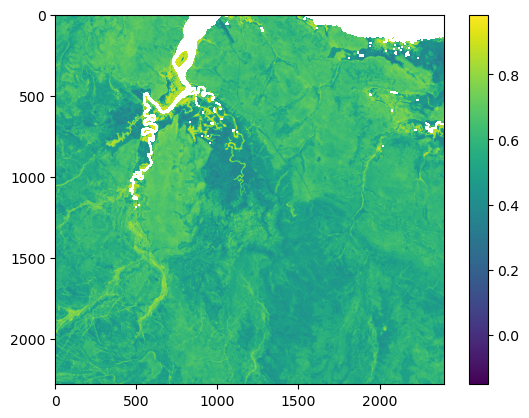

In [6]:
print(ndvi_meta)
print(raster_transform)
print(ndvi_global.shape)

# from the stack of local layers
ndvi_max = 0.8220
ndvi_min = -0.2772

ndvi_global_tens = torch.from_numpy(ndvi_global)

# Normalizing the data
ndvi_global_norm = (ndvi_global_tens - ndvi_min) / (ndvi_max - ndvi_min)

plt.imshow(ndvi_global_norm.numpy())
plt.colorbar()  
plt.show()


### Canopy cover

In [7]:
file_path = '../mapping/cropped rasters/canopy_cover.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    canopy_global = src.read(1)
    # Get the metadata of the raster
    canopy_meta = src.meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


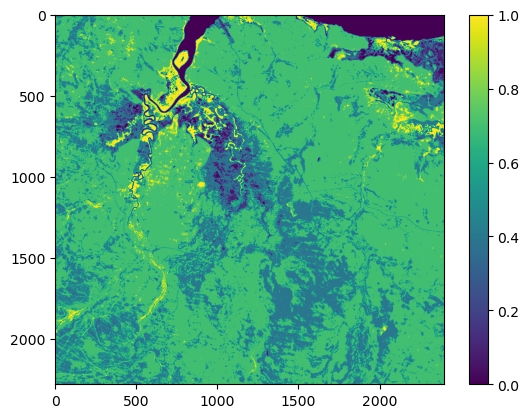

In [8]:
print(canopy_meta)
print(canopy_global.shape)

# from the stack of local layers
canopy_max = 82.5000
canopy_min = 0.0

canopy_global_tens = torch.from_numpy(canopy_global)

# Normalizing the data
canopy_global_norm = (canopy_global_tens - canopy_min) / (canopy_max - canopy_min)

plt.imshow(canopy_global_norm.numpy())
plt.colorbar()  
plt.show()


### Herbaceous vegetation

In [9]:
file_path = '../mapping/cropped rasters/veg_herby.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    herby_global = src.read(1)
    # Get the metadata of the raster
    herby_meta = src.meta


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


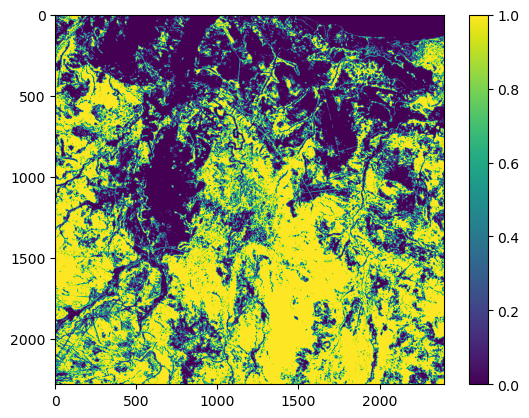

In [10]:
print(herby_meta)
print(herby_global.shape)

# from the stack of local layers
herby_max = 1.0
herby_min = 0.0

herby_global_tens = torch.from_numpy(herby_global)

# Normalizing the data
herby_global_norm = (herby_global_tens - herby_min) / (herby_max - herby_min)

plt.imshow(herby_global_norm.numpy())
plt.colorbar()  
plt.show()


### Slope

In [11]:
file_path = '../mapping/cropped rasters/slope.tif'
# read the raster file
with rasterio.open(file_path) as src:
    # Read the raster band as separate variable
    slope_global = src.read(1)
    # Get the metadata of the raster
    slope_meta = src.meta
    slope_transform = src.transform # same as the raster transform in the NDVI raster read

print(slope_global)
print(slope_transform)


[[       nan        nan        nan ...        nan        nan        nan]
 [       nan 0.3352837  0.39781624 ... 0.         0.                nan]
 [       nan 0.3983888  0.48142004 ... 0.         0.                nan]
 ...
 [       nan 2.215875   1.9798415  ... 1.5078747  1.268342          nan]
 [       nan 1.9740707  1.7354656  ... 1.697194   1.4880029         nan]
 [       nan        nan        nan ...        nan        nan        nan]]
| 25.00, 0.00, 0.00|
| 0.00,-25.00,-1406000.00|
| 0.00, 0.00, 1.00|


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 2400, 'height': 2280, 'count': 1, 'crs': CRS.from_epsg(3112), 'transform': Affine(25.0, 0.0, 0.0,
       0.0, -25.0, -1406000.0)}
(2280, 2400)


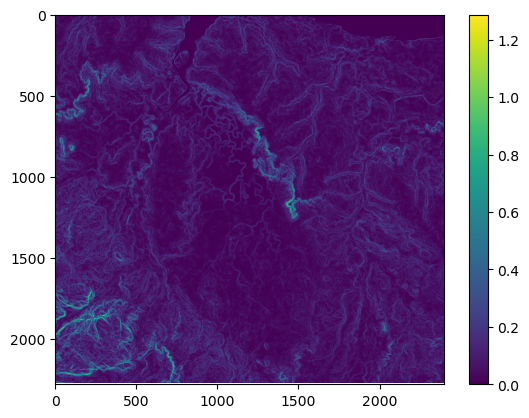

In [12]:
print(slope_meta)
print(slope_global.shape)

# from the stack of local layers
slope_max = 12.2981
slope_min = 0.0006

slope_global_tens = torch.from_numpy(slope_global)

# Normalizing the data
slope_global_norm = (slope_global_tens - slope_min) / (slope_max - slope_min)

plt.imshow(slope_global_norm.numpy())
plt.colorbar()  
plt.show()


Testing functions for selecting subsets of the raster layer, using torch objects

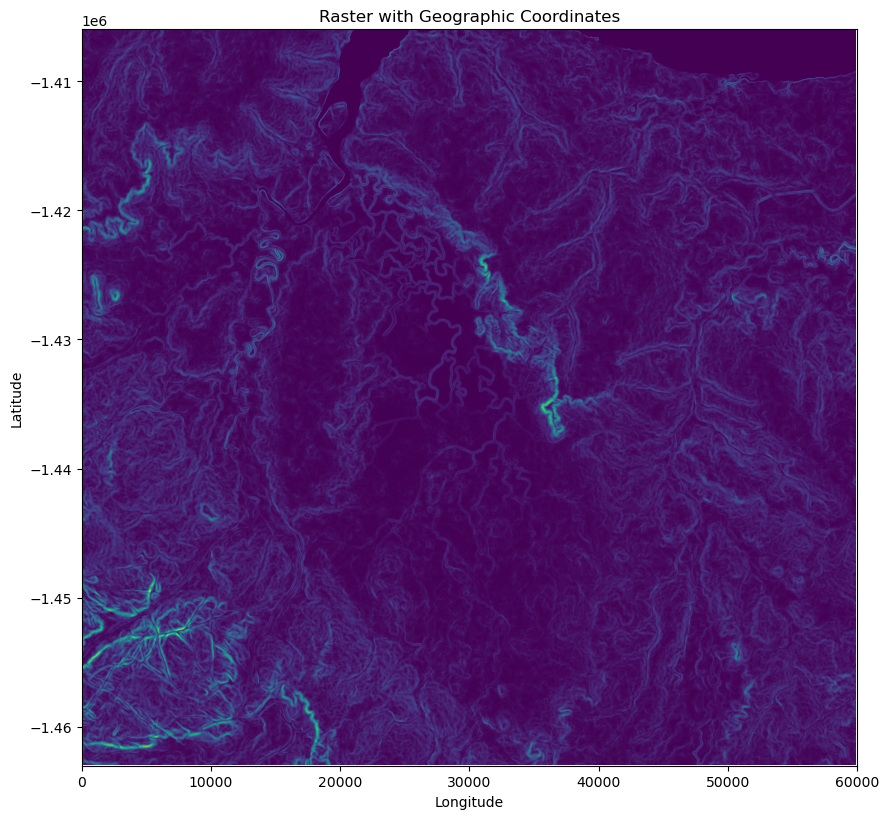

In [13]:
# Create a figure and axis with matplotlib
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the raster
show(slope_global, transform=raster_transform, ax=ax, cmap='viridis')

# Set the title and labels
ax.set_title('Raster with Geographic Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [155]:
x, y = 5.9e4, -1.447e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

59000.0 -1447000.0
2360 1640


In [156]:
window_size = 101

# Define half the window size
half_window = window_size // 2

# Calculate the window boundaries
row_start = py - half_window
row_stop = py + half_window + 1
col_start = px - half_window
col_stop = px + half_window + 1

# Initialize the subset array with zeros (or any other padding value)
subset = np.zeros((window_size, window_size), dtype=slope_global.dtype)

# Calculate the valid region within the raster bounds
valid_row_start = max(0, row_start)
valid_row_stop = min(slope_global.shape[0], row_stop)
valid_col_start = max(0, col_start)
valid_col_stop = min(slope_global.shape[1], col_stop)

# Calculate the corresponding region in the subset array
subset_row_start = valid_row_start - row_start
subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
subset_col_start = valid_col_start - col_start
subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)

# Copy the valid region from the raster array to the subset array
subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
    slope_global[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]

Plot the raster layer

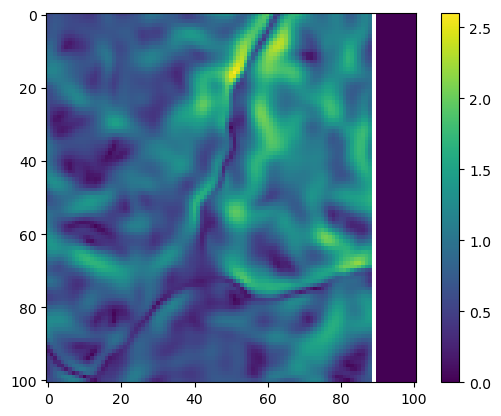

In [157]:
# plot the subset
plt.imshow(subset, cmap='viridis')
plt.colorbar()
plt.show()

## Subset function

In [77]:
def subset_raster_with_padding_torch(raster_tensor, x, y, window_size, transform):
    # Convert geographic coordinates to pixel coordinates
    px, py = ~transform * (x, y)
    
    # Round pixel coordinates to integers
    px, py = int(round(px)), int(round(py))
    
    # Define half the window size
    half_window = window_size // 2
    
    # Calculate the window boundaries
    row_start = py - half_window
    row_stop = py + half_window + 1
    col_start = px - half_window
    col_stop = px + half_window + 1
    
    # Initialize the subset tensor with zeros (or any other padding value)
    subset = torch.zeros((window_size, window_size), dtype=raster_tensor.dtype)
    
    # Calculate the valid region within the raster bounds
    valid_row_start = max(0, row_start)
    valid_row_stop = min(raster_tensor.shape[0], row_stop)
    valid_col_start = max(0, col_start)
    valid_col_stop = min(raster_tensor.shape[1], col_stop)
    
    # Calculate the corresponding region in the subset tensor
    subset_row_start = valid_row_start - row_start
    subset_row_stop = subset_row_start + (valid_row_stop - valid_row_start)
    subset_col_start = valid_col_start - col_start
    subset_col_stop = subset_col_start + (valid_col_stop - valid_col_start)
    
    # Copy the valid region from the raster tensor to the subset tensor
    subset[subset_row_start:subset_row_stop, subset_col_start:subset_col_stop] = \
        raster_tensor[valid_row_start:valid_row_stop, valid_col_start:valid_col_stop]
    
    return subset, col_start, row_start

Testing the subset function

Text(0.5, 1.0, 'Slope Subset')

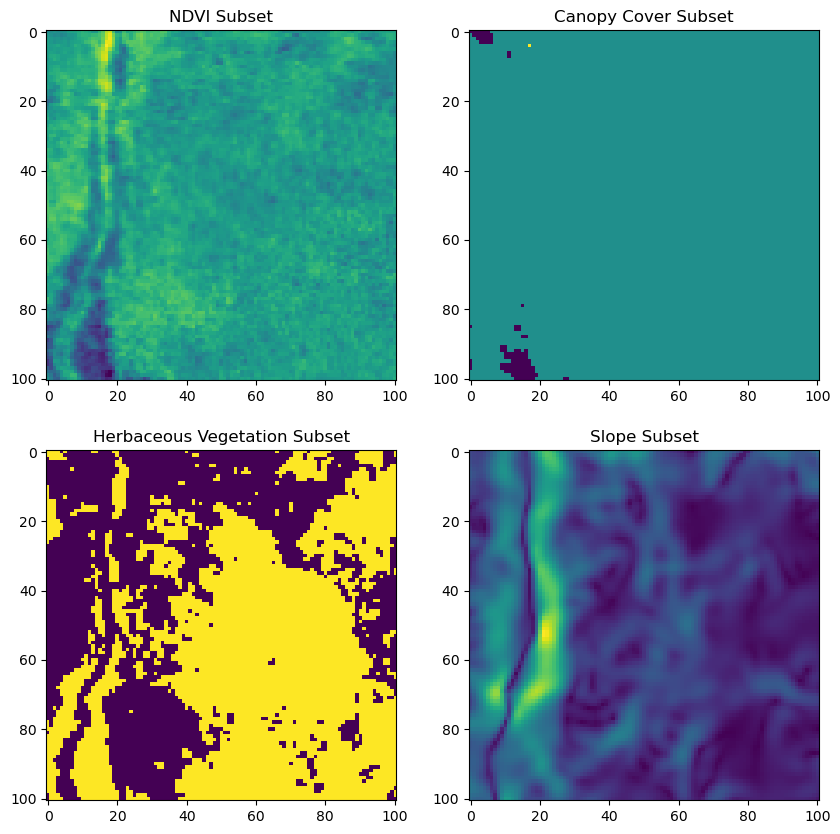

In [244]:
x = 5.8e4
y = -1.435e6
window_size = 101

ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm, x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI Subset')
# axs[0, 0].axis('off')

axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy Cover Subset')
# axs[0, 1].axis('off')

axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous Vegetation Subset')
# axs[1, 0].axis('off')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')
# axs[1, 1].axis('off')



In [245]:
x = 3.7e4
y = -1.435e6
print(x, y)

# Convert geographic coordinates to pixel coordinates
px, py = ~raster_transform * (x, y)
# Round pixel coordinates to integers
px, py = int(round(px)), int(round(py))

# Print the pixel coordinates	
print(px, py)

37000.0 -1435000.0
1480 1160


# Running the model on the subset layers

### Set the device for the model

In [246]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using {device} device")

Using cpu device


# Define the model

In [20]:
class Conv2d_block_toFC(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_toFC, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        self.kernel_size_mp = params.kernel_size_mp
        self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=self.kernel_size_mp, stride=self.stride_mp),
        nn.Flatten())

    def forward(self, x):
        return self.conv2d(x)
    
class Conv2d_block_spatial(nn.Module):
    def __init__(self, params):
        super(Conv2d_block_spatial, self).__init__()
        self.batch_size = params.batch_size
        self.input_channels = params.input_channels
        self.output_channels = params.output_channels
        self.kernel_size = params.kernel_size
        self.stride = params.stride
        # self.kernel_size_mp = params.kernel_size_mp
        # self.stride_mp = params.stride_mp
        self.padding = params.padding
        self.image_dim = params.image_dim
        self.device = params.device

        self.conv2d = nn.Sequential(
        nn.Conv2d(in_channels=self.input_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=self.output_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding),
        nn.ReLU(),
        nn.Conv2d(in_channels=self.output_channels, out_channels=1, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        )

    def forward(self, x):

        print("Shape before squeeze:", self.conv2d(x).shape)
        conv2d_spatial = self.conv2d(x).squeeze(dim = 1)
        print("Shape before logsumexp:", conv2d_spatial.shape)

        conv2d_spatial = conv2d_spatial - torch.logsumexp(conv2d_spatial, dim = (1, 2), keepdim = True)
        # conv2d_spatial = conv2d_spatial/torch.sum(conv2d_spatial)
        return conv2d_spatial

class FCN_block_all_habitat(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_habitat, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.image_dim * self.image_dim)
        )
    
    def forward(self, x):
        return self.ffn(x)


class FCN_block_all_movement(nn.Module):
    def __init__(self, params):
        super(FCN_block_all_movement, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_all = params.dense_dim_in_all
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.num_movement_params = params.num_movement_params
        self.dropout = params.dropout

        self.ffn = nn.Sequential(nn.Linear(self.dense_dim_in_all, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.num_movement_params)
        )
    
    def forward(self, x):
        return self.ffn(x)
    
class FCN_block_nonspatial(nn.Module):
    def __init__(self, params):
        super(FCN_block_nonspatial, self).__init__()
        self.batch_size = params.batch_size
        self.dense_dim_in_nonspatial = params.dense_dim_in_nonspatial
        self.dense_dim_hidden = params.dense_dim_hidden
        self.dense_dim_out = params.dense_dim_out
        self.image_dim = params.image_dim
        self.device = params.device
        self.dropout = params.dropout

        self.ffn = nn.Sequential(nn.Linear(self.dense_dim_in_nonspatial, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_hidden),
            nn.Dropout(self.dropout),
            nn.ReLU(),
            nn.Linear(self.dense_dim_hidden, self.dense_dim_out)
        )
    
    def forward(self, x):
        return self.ffn(x)

class Params_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Params_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.pixel_size = params.pixel_size
        self.center = self.image_dim // 2
        y, x = np.indices((self.image_dim, self.image_dim))
        self.distance_layer = torch.from_numpy(np.sqrt((self.pixel_size*(x - self.center))**2 + (self.pixel_size*(y - self.center))**2))
        # change the centre cell to the average distance from the centre to the edge of the pixel
        self.distance_layer[self.center, self.center] = 0.56*self.pixel_size # average distance from the centre to the perimeter of the pixel (accounting for longer distances at the corners)
        self.bearing_layer = torch.from_numpy(np.arctan2(y - self.center, x - self.center))
        self.device = params.device

    def gamma_density(self, x, shape, scale):
        return -1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale
        # return torch.exp(-1*torch.lgamma(shape) -shape*torch.log(scale) + (shape - 1)*torch.log(x) - x/scale)
    
    def vonmises_density(self, x, kappa, loc):
        return kappa*torch.cos(x - loc) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa)))
        # return torch.exp(kappa*torch.cos(x - loc) - 1*(np.log(2*torch.pi) + torch.log(torch.special.i0(kappa))))
    
    def forward(self, x):
        gamma_shape = torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        # gamma_shape = 1.0 + torch.exp(x[:, 0]).unsqueeze(0).unsqueeze(0)
        gamma_shape = gamma_shape.repeat(self.image_dim, self.image_dim, 1)
        gamma_shape = gamma_shape.permute(2, 0, 1)

        gamma_scale = torch.exp(x[:, 1]).unsqueeze(0).unsqueeze(0)
        gamma_scale = gamma_scale.repeat(self.image_dim, self.image_dim, 1)
        gamma_scale = gamma_scale.permute(2, 0, 1)

        vonmises_kappa = torch.exp(x[:, 2]).unsqueeze(0).unsqueeze(0)
        vonmises_kappa = vonmises_kappa.repeat(self.image_dim, self.image_dim, 1)
        vonmises_kappa = vonmises_kappa.permute(2, 0, 1)

        vonmises_loc = x[:, 3].unsqueeze(0).unsqueeze(0)
        vonmises_loc = vonmises_loc.repeat(self.image_dim, self.image_dim, 1)
        vonmises_loc = vonmises_loc.permute(2, 0, 1)

        gamma_density_layer = self.gamma_density(self.distance_layer, gamma_shape, gamma_scale)
        vonmises_density_layer = self.vonmises_density(self.bearing_layer, vonmises_kappa, vonmises_loc)

        # movement_grid = gamma_density_layer*vonmises_density_layer
        # movement_grid = movement_grid/torch.sum(movement_grid)

        movement_grid = gamma_density_layer + vonmises_density_layer # when the Gamma and von Mises densities are on the log-scale
        movement_grid = movement_grid - torch.logsumexp(movement_grid, dim = (1, 2), keepdim = True)

        return movement_grid

class Vector_to_Grid_Block(nn.Module):
    def __init__(self, params):
        super(Vector_to_Grid_Block, self).__init__()
        self.batch_size = params.batch_size
        self.image_dim = params.image_dim
        self.device = params.device
    
    def forward(self, x):
        x_unnorm = x.reshape(x.shape[0], self.image_dim, self.image_dim)
        x_norm = x_unnorm - torch.logsumexp(x_unnorm, dim = (1, 2), keepdim = True)
        return x_norm
    
        # x_norm = x_unnorm/torch.sum(x_unnorm)
        # return x_norm


class ConvJointModel(nn.Module):
    def __init__(self, params):
        super(ConvJointModel, self).__init__()
        # self.conv_habitat = Conv2d_block(params)
        # self.fcn_habitat_all = FCN_block_all_habitat(params)
        # self.fcn_habitat_nonspatial = FCN_block_nonspatial(params)
        # self.habitat_grid_output = Vector_to_Grid_Block(params)

        self.conv_habitat = Conv2d_block_spatial(params)

        self.conv_movement = Conv2d_block_toFC(params)
        self.fcn_movement_all = FCN_block_all_movement(params)
        self.fcn_movement_nonspatial = FCN_block_nonspatial(params)
        self.movement_grid_output = Params_to_Grid_Block(params)
        self.device = params.device



    def forward(self, x):
        spatial_data_x = x[0]
        additional_data_x = x[1]

        # conv_habitat = self.conv_habitat(spatial_data_x)
        # covariates_habitat = self.fcn_habitat_nonspatial(additional_data_x)
        # all_predictors_habitat = torch.cat([conv_habitat, covariates_habitat], dim = 1)
        # # print(f"Shape after concatenation: {all_predictors_habitat.shape}")  # Debugging print
        # output_habitat = self.fcn_habitat_all(all_predictors_habitat)
        # output_habitat = self.habitat_grid_output(output_habitat)

        output_habitat = self.conv_habitat(spatial_data_x)
        # print(f"Shape after CNN habitat: {output_habitat.shape}")  # Debugging print

        conv_movement = self.conv_movement(spatial_data_x)
        # print(f"Shape after CNN to FC movement: {conv_movement.shape}")  # Debugging print
        covariates_movement = self.fcn_movement_nonspatial(additional_data_x)
        # print(f"Shape after fcn_movement_nonspatial: {covariates_movement.shape}")  # Debugging print
        all_predictors_movement = torch.cat([conv_movement, covariates_movement], dim = 1)
        # print(f"Shape after torch.cat([conv_movement, covariates_movement], dim = 1): {all_predictors_movement.shape}")  # Debugging print
        output_movement = self.fcn_movement_all(all_predictors_movement)
        # print(f"Shape after fcn_movement_all: {output_movement.shape}")  # Debugging print
        output_movement = self.movement_grid_output(output_movement)
        # print(f"Shape after CNN movement: {output_movement.shape}")  # Debugging print

        output = torch.stack((output_habitat, output_movement), dim = -1)
        return output
    
class ModelParams():
    def __init__(self, dict_params):
        self.batch_size = dict_params["batch_size"]
        self.image_dim = dict_params["image_dim"]
        self.pixel_size = dict_params["pixel_size"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_nonspatial = dict_params["dense_dim_in_nonspatial"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.dense_dim_in_all = dict_params["dense_dim_in_all"]
        self.dense_dim_hidden = dict_params["dense_dim_hidden"]
        self.dense_dim_out = dict_params["dense_dim_out"]
        self.batch_size = dict_params["batch_size"]
        self.input_channels = dict_params["input_channels"]
        self.output_channels = dict_params["output_channels"]
        self.kernel_size = dict_params["kernel_size"]
        self.stride = dict_params["stride"]
        self.kernel_size_mp = dict_params["kernel_size_mp"]
        self.stride_mp = dict_params["stride_mp"]
        self.padding = dict_params["padding"]
        self.image_dim = dict_params["image_dim"]
        self.num_movement_params = dict_params["num_movement_params"]
        self.dropout = dict_params["dropout"]
        self.device = dict_params["device"]


## Instantiate the model

In [21]:
params_dict = {"batch_size": 32,
               "image_dim": 101, #number of pixels along the edge of each local patch/image
               "pixel_size": 25, #number of metres along the edge of a pixel
               "dense_dim_in_nonspatial": 2, #change this to however many other scalar predictors you have (bearing, velocity etc)
               "dense_dim_hidden": 128, #number of nodes in the hidden layers
               "dense_dim_out": 128, #number of nodes in the output of the fully connected block (FCN)
               "dense_dim_in_all": 2500 + 128, #number of inputs entering the fully connected block once the nonspatial features have been concatenated to the spatial features
               "input_channels": 4, #number of spatial layers in each image
               "output_channels": 4, #number of filters to learn
               "kernel_size": 3, #the size of the 2D moving windows / kernels that are being learned
               "stride": 1, #the stride used when applying the kernel.  This reduces the dimension of the output if set to greater than 1
               "kernel_size_mp": 2, #the size of the kernel that is used in max pooling operations
               "stride_mp": 2, #the stride that is used in max pooling operations
               "padding": 1, #the amount of padding to apply to images prior to applying the 2D convolution
               "num_movement_params": 4, #number of parameters used to parameterise the movement kernel
               "dropout": 0.1,
               "device": device
               }

params = ModelParams(params_dict)
model = ConvJointModel(params).to(device)
# print(model)

In [22]:
# load the model structure
# model = torch.load('CNN_model_global.pth')
# model.eval()

# # load the model weights
# print(model.state_dict())
model.load_state_dict(torch.load('checkpoint_CNN_global_buffalo.pt'))
print(model.state_dict())

model.eval()

OrderedDict([('conv_habitat.conv2d.0.weight', tensor([[[[-0.0080,  0.1322,  0.1209],
          [ 0.0810,  0.0848,  0.2683],
          [ 0.1356,  0.1685,  0.0847]],

         [[ 0.0348, -0.0309, -0.0468],
          [-0.2214,  0.0487, -0.0261],
          [ 0.0916, -0.1313, -0.1614]],

         [[-0.1274, -0.1357, -0.0396],
          [ 0.0897, -0.0077, -0.4687],
          [ 0.0442, -0.1001,  0.0969]],

         [[-0.1806,  0.0477, -0.0006],
          [-0.0360,  0.0716, -0.1257],
          [-0.1060, -0.0562,  0.0732]]],


        [[[-0.0721,  0.0829, -0.1202],
          [ 0.1429, -0.0422,  0.1644],
          [ 0.0345,  0.1073, -0.0784]],

         [[-0.0224,  0.0657,  0.1173],
          [-0.2454, -0.0110, -0.1035],
          [-0.1806, -0.3209, -0.0148]],

         [[ 0.2142,  0.0752,  0.1207],
          [ 0.0040, -0.1090, -0.0515],
          [-0.2392, -0.2588,  0.2261]],

         [[ 0.1090,  0.2060,  0.1221],
          [-0.1203,  0.0008, -0.1622],
          [-0.0223,  0.0529,  0.0248]]],


ConvJointModel(
  (conv_habitat): Conv2d_block_spatial(
    (conv2d): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (conv_movement): Conv2d_block_toFC(
    (conv2d): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (fcn_movement_all): FCN_block_all_movement(
    (ffn): Sequential(
      (0): Linear(in_features=2628, out_features=128, bias=True)
      (1): Dropout(p=0.1, inplace=Fal

## Setup simulation parameters

In [247]:
n_steps = 100

Testing the subset function

Text(0.5, 1.0, 'Slope Subset')

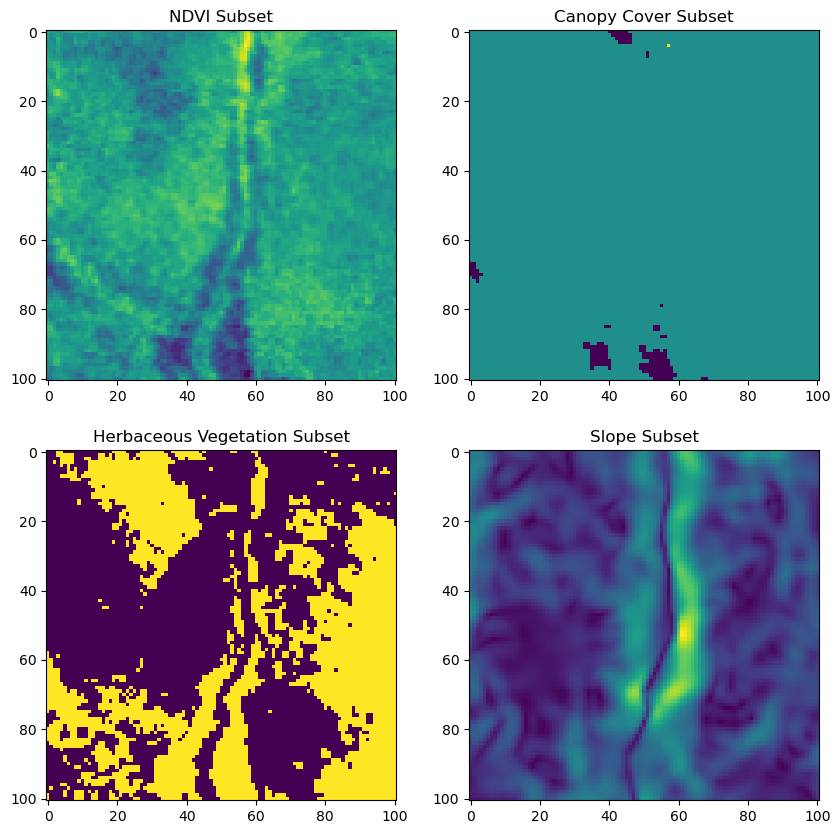

In [248]:
x = 5.7e4
y = -1.435e6
window_size = 101

ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm, x, y, window_size, raster_transform)
canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, raster_transform)
herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, raster_transform)
slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, raster_transform)

# Plot the subset
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].imshow(ndvi_subset.numpy(), cmap='viridis')
axs[0, 0].set_title('NDVI Subset')
# axs[0, 0].axis('off')

axs[0, 1].imshow(canopy_subset.numpy(), cmap='viridis')
axs[0, 1].set_title('Canopy Cover Subset')
# axs[0, 1].axis('off')

axs[1, 0].imshow(herby_subset.numpy(), cmap='viridis')
axs[1, 0].set_title('Herbaceous Vegetation Subset')
# axs[1, 0].axis('off')

axs[1, 1].imshow(slope_subset.numpy(), cmap='viridis')
axs[1, 1].set_title('Slope Subset')
# axs[1, 1].axis('off')



## Stack the subset layers

In [249]:
# Stack the channels along a new axis; here, 1 is commonly used for channel axis in PyTorch
subset_stack = torch.stack([ndvi_subset, canopy_subset, herby_subset, slope_subset], dim=0)
subset_stack
x1 = subset_stack
x1 = x1.unsqueeze(0)
print(x1.shape)
# print(x1)

torch.Size([1, 4, 101, 101])


### Additional data

In [250]:
def repeat_sequence(sequence, length_out):
    return np.resize(sequence, length_out)

hour_t2 = np.resize(range(24), n_steps)
print(hour_t2)

yday_sequence = np.repeat(range(250, 365), 24)
yday_t2 = np.resize(yday_sequence, n_steps)
print(yday_t2)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
yday_t2_tensor = torch.tensor(yday_t2).float()

# Stack tensors column-wise to create a tensor of shape [100, 2]
x2_full = torch.stack((hour_t2_tensor, yday_t2_tensor), dim=1)

# print(x2.shape)  # Should output torch.Size([100, 2])
# print(x2)

# x2 = torch.tensor([hour_t2, yday_t2]).float()
# x2 = x2.unsqueeze(0)
print(x2_full.shape)
# print(x2)
print(x2_full[59,:])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
  0  1  2  3]
[250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250 250
 250 250 250 250 250 250 251 251 251 251 251 251 251 251 251 251 251 251
 251 251 251 251 251 251 251 251 251 251 251 251 252 252 252 252 252 252
 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252 252
 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253 253
 253 253 253 253 253 253 254 254 254 254]
torch.Size([100, 2])
tensor([ 11., 252.])


## Run the model on the subsetted layers

Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])


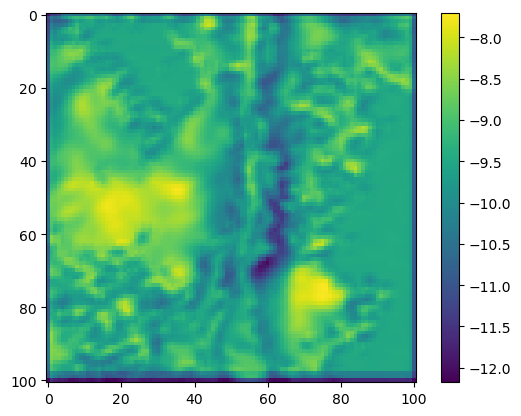

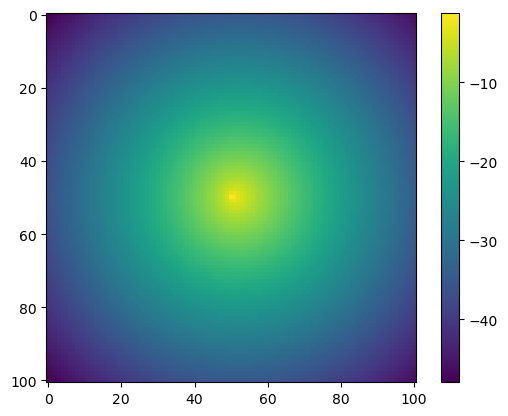

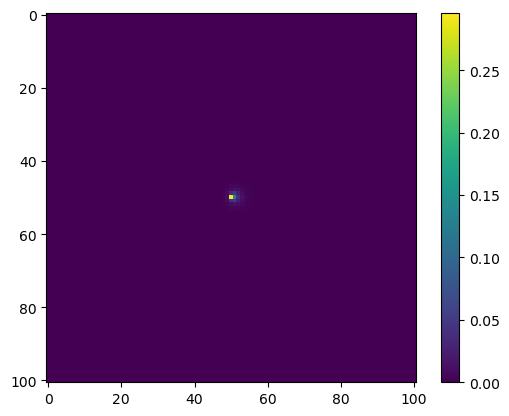

torch.Size([101, 101])


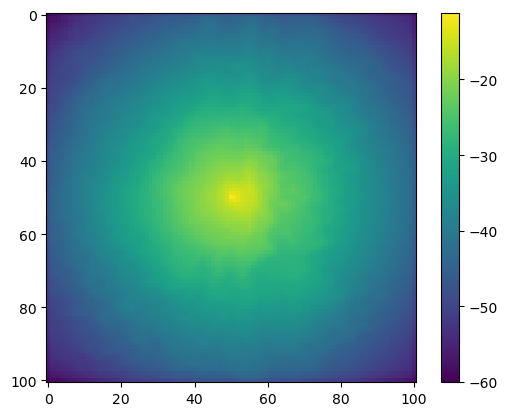

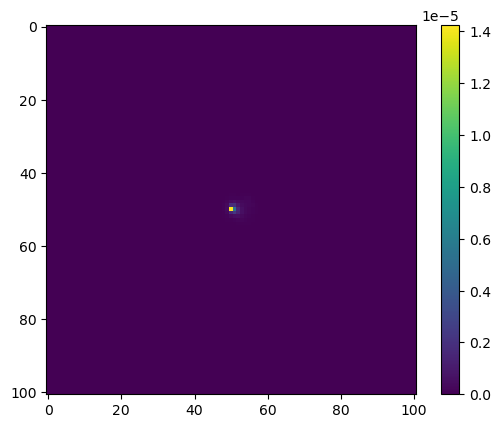

In [251]:
# print(x1.shape)
# print(x2[1,:].unsqueeze(0).shape)

# # print(x1)
# print(x2[1,:].unsqueeze(0).detach().numpy()[0,:])
# # print(x2[53,:], keep)

test = model((x1, x2_full[40,:].unsqueeze(0)))

# test = model((x1, x2[1,:].unsqueeze(0)))
# print(test.shape)
# # print(test)

# with random input
# test_batch = 1
# x1 = (torch.rand(test_batch, 4, 101, 101, device=device)) #spatial data
# x2 = (torch.rand(test_batch, 2, device=device)) #other scalar covariates
# test = model((x1, x2))

# plot the results of the habitat density as an image
plt.imshow(test.detach().numpy()[0,:,:,0])
plt.colorbar()
plt.show()

# plot the results of the movement density as an image
plt.imshow(test.detach().numpy()[0,:,:,1])
plt.colorbar()
plt.show()

# plot the results of the exp movement density as an image
plt.imshow(np.exp(test.detach().numpy()[0,:,:,1]))
plt.colorbar()
plt.show()

test_cat = (test[:, :, :, 0] + test[:, :, :, 1])
# test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
# test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

test_cat = test_cat.squeeze()

print(test_cat.shape)

plt.imshow(test_cat.detach().numpy()[:,:])
plt.colorbar()
plt.show()

plt.imshow(np.exp(test_cat.detach().numpy()[:,:]))
plt.colorbar()
plt.show()

## Sample from the probability surface

In [256]:
# sample from the array values
test_cat_exp = torch.exp(test_cat)
test_cat_exp = test_cat_exp/torch.sum(test_cat_exp)
# print(test_cat_exp)
print(torch.sum(test_cat_exp))

# Flatten the probability surface
flat_prob_surface = test_cat_exp.flatten().detach().numpy()
print(flat_prob_surface)

# Generate the corresponding indices for the flattened array
indices = np.arange(flat_prob_surface.size)

# Sample from the flattened probability surface
sampled_index = np.random.choice(indices, p=flat_prob_surface)

# Convert the sampled index back to 2D coordinates
sampled_coordinates = np.unravel_index(sampled_index, test_cat_exp.shape)

print("Sampled coordinates:", sampled_coordinates)

tensor(1., dtype=torch.float64, grad_fn=<SumBackward0>)
[1.99671611e-22 5.70350826e-22 8.26512544e-22 ... 3.64605976e-21
 2.52729929e-21 1.12435596e-21]
Sampled coordinates: (50, 51)


## Return sampled point to geographic coordinates

In [258]:
# original locations
print(x ,y)
print(sampled_coordinates)
print(px, py)

# row_start = py - half_window
# row_stop = py + half_window + 1
# col_start = px - half_window
# col_stop = px + half_window + 1

print(row_start, col_start)
new_px = origin_x + sampled_coordinates[0]
new_py = origin_y + sampled_coordinates[1]
print(new_px)
print(new_py)

# Convert geographic coordinates to pixel coordinates
new_x, new_y = raster_transform * (new_px, new_py)
print(new_x, new_y)

57000.0 -1435000.0
(50, 51)
1480 1160
1590 2310
2280
1161
57000.0 -1435025.0


# Full trajectory function

In [203]:
def simulate_trajectory(global_raster_tensors, 
                        additional_data_tensor,
                        window_size, 
                        x_loc, 
                        y_loc,
                        global_raster_transform):
    # Convert geographic coordinates to pixel coordinates
    x = x_loc
    y = y_loc

    # ndvi_subset, origin_x, origin_y = subset_raster_with_padding_torch(ndvi_global_norm, x, y, window_size, global_raster_transform)
    # canopy_subset, origin_x, origin_y = subset_raster_with_padding_torch(canopy_global_norm, x, y, window_size, global_raster_transform)
    # herby_subset, origin_x, origin_y = subset_raster_with_padding_torch(herby_global_norm, x, y, window_size, global_raster_transform)
    # slope_subset, origin_x, origin_y = subset_raster_with_padding_torch(slope_global_norm, x, y, window_size, global_raster_transform)

    # Apply the processing function to each tensor in the list
    # subset_rasters_tensors, origin_x, origin_y = [subset_raster_with_padding_torch(raster_tensor, x=start_x, y=start_y, window_size=101, transform=raster_transform) for raster_tensor in global_raster_tensors]
    # print(subset_rasters_tensors.shape)
    
    results = [subset_raster_with_padding_torch(raster_tensor, x=x_loc, y=y_loc, window_size=window_size, transform=global_raster_transform) for raster_tensor in global_raster_tensors]
    
    # Unpacking the results
    subset_rasters_tensors, origin_xs, origin_ys = zip(*results)
    # print(subset_rasters_tensors.shape)
    
    # Stack the processed tensors along a new dimension (e.g., dimension 0)
    x1 = torch.stack(subset_rasters_tensors, dim=0)
    x1 = x1.unsqueeze(0)
    print(x1.shape)

    x2 = additional_data_tensor

    test = model((x1, x2))
    print(test.shape)

    test_cat = (test[:, :, :, 0] + test[:, :, :, 1])
    # test_cat = torch.log(test[:, :, :, 0]*test[:, :, :, 1])
    # test_cat = -1 * test[:, :, :, 0] * torch.exp(test[:, :, :, 1])

    test_cat = test_cat.squeeze()

    print(test_cat.shape)

    plt.imshow(test_cat.detach().numpy()[:,:])
    plt.colorbar()
    plt.show()

    plt.imshow(np.exp(test_cat.detach().numpy()[:,:]))
    plt.colorbar()
    plt.show()

    # sample from the array values
    test_cat_exp = torch.exp(test_cat)
    test_cat_exp = test_cat_exp/torch.sum(test_cat_exp)
    # print(test_cat_exp)
    # print(torch.sum(test_cat_exp))

    # Flatten the probability surface
    flat_prob_surface = test_cat_exp.flatten().detach().numpy()
    # print(flat_prob_surface)

    # Generate the corresponding indices for the flattened array
    indices = np.arange(flat_prob_surface.size)

    # Sample from the flattened probability surface
    sampled_index = np.random.choice(indices, p=flat_prob_surface)

    # Convert the sampled index back to 2D coordinates
    sampled_coordinates = np.unravel_index(sampled_index, test_cat_exp.shape)

    print("Sampled coordinates:", sampled_coordinates)

    # recover the geographic coordinates of the sampled location
    new_px = origin_xs[0] + sampled_coordinates[0]
    new_py = origin_ys[0] + sampled_coordinates[1]
    print(new_px)
    print(new_py)

    # Convert geographic coordinates to pixel coordinates
    new_x, new_y = raster_transform * (new_px, new_py)
    print(new_x, new_y)

    return new_x, new_y


## Call the function

tensor([[ 11., 251.]])
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


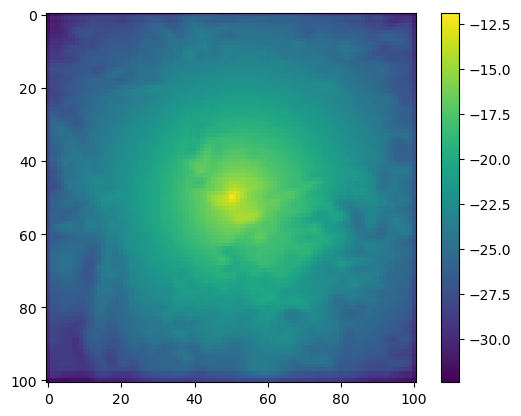

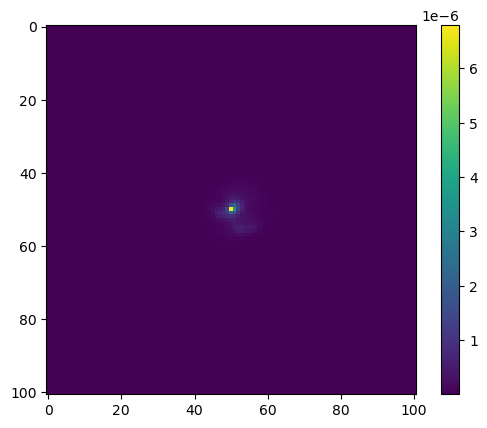

Sampled coordinates: (39, 54)
2309
1064
57725.0 -1432600.0


(57725.0, -1432600.0)

In [261]:
global_raster_list = [ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm]
x2 = x2_full[35,:].unsqueeze(0)
print(x2)

simulate_trajectory(global_raster_tensors=global_raster_list,
                    additional_data_tensor=x2,
                    window_size=101,
                    x_loc=5.8e4,
                    y_loc=-1.4325e6,
                    global_raster_transform=raster_transform)

# Generate trajectory

## Setup parameters

In [197]:
# Setup the simulation parameters
n_steps = 10
starting_yday = 3
start_x = 3.0e4
start_y = -1.4325e6
global_raster_list = [ndvi_global_norm, canopy_global_norm, herby_global_norm, slope_global_norm]
window_size = 101
global_raster_transform = raster_transform


## Create simulation inputs from the parameters

In [263]:
x = np.repeat(0., n_steps)
y = np.repeat(0., n_steps)
# print(x)

x[0], y[0] = start_x, start_y
# print(x, y)

# Create sequence of steps
step = range(1, n_steps)
# print(step)

# Create sequence of hours
hour_t2 = np.resize(range(24), n_steps)
# print(hour_t2)

# Create sequence of days of the year
yday_sequence = np.repeat(range(1, 365), 24)
yday_t2 = yday_sequence[yday_sequence > starting_yday - 1]
yday_t2 = np.resize(yday_t2, n_steps)
# print(yday_t2)

# Convert lists to PyTorch tensors
hour_t2_tensor = torch.tensor(hour_t2).float()
yday_t2_tensor = torch.tensor(yday_t2).float()

# Stack tensors column-wise to create a tensor of shape [100, 2]
x2_full = torch.stack((hour_t2_tensor, yday_t2_tensor), dim=1)
# print(x2.shape)

## Trajectory loop

torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


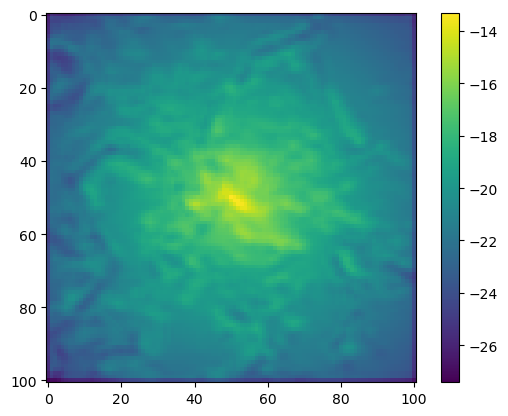

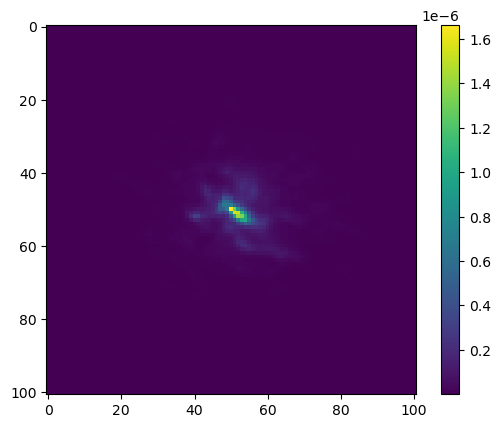

Sampled coordinates: (39, 72)
1189
1082
29725.0 -1433050.0
29725.0 -1433050.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


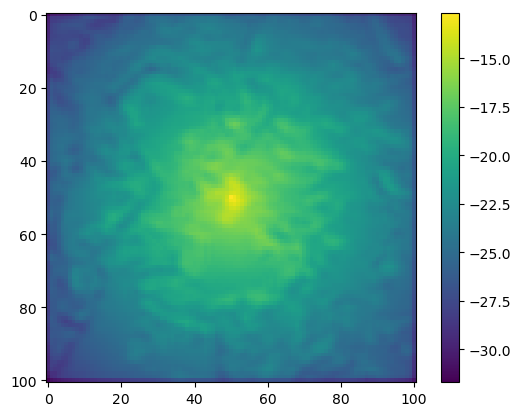

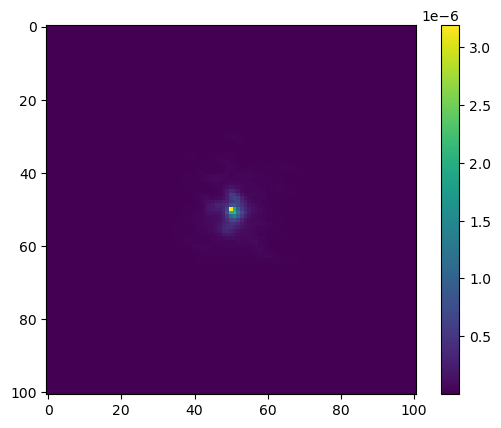

Sampled coordinates: (52, 51)
1191
1083
29775.0 -1433075.0
29775.0 -1433075.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


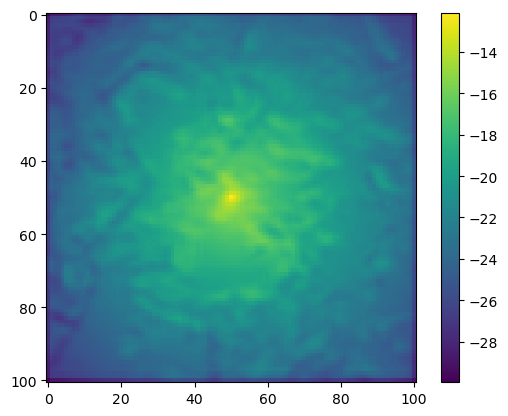

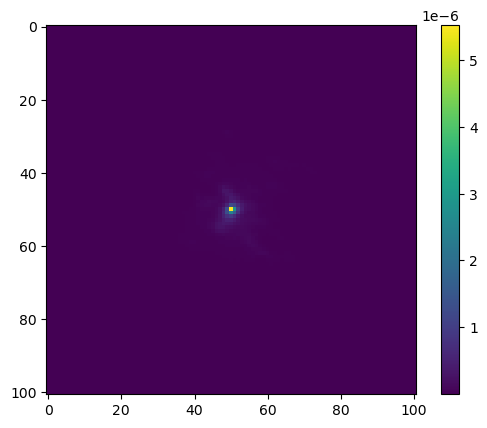

Sampled coordinates: (49, 48)
1190
1081
29750.0 -1433025.0
29750.0 -1433025.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


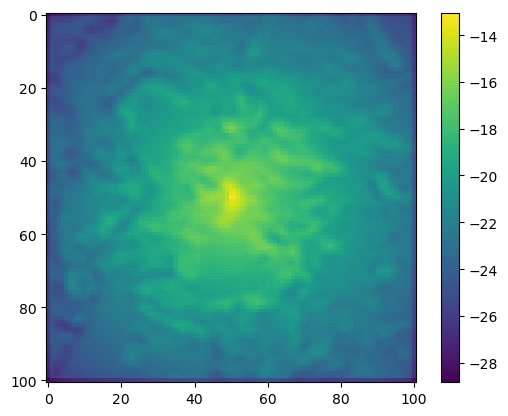

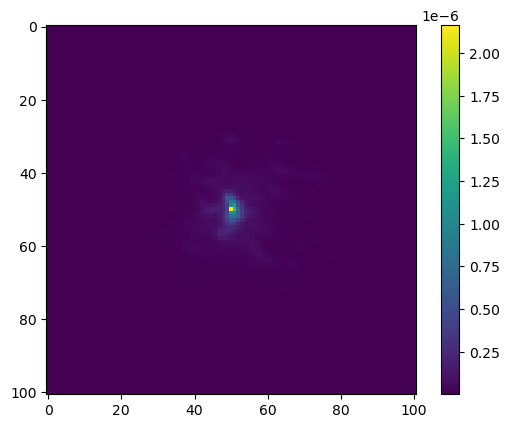

Sampled coordinates: (41, 50)
1181
1081
29525.0 -1433025.0
29525.0 -1433025.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


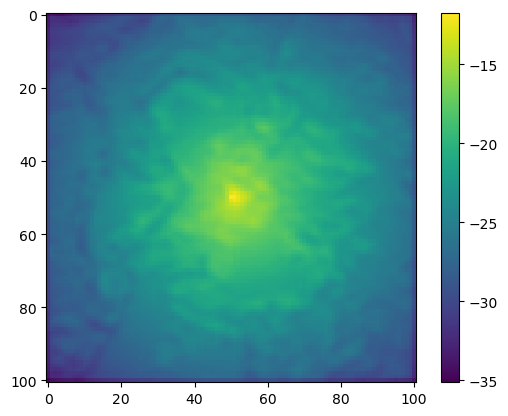

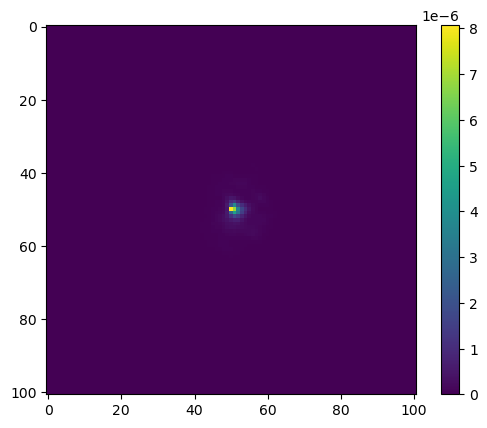

Sampled coordinates: (39, 52)
1170
1083
29250.0 -1433075.0
29250.0 -1433075.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


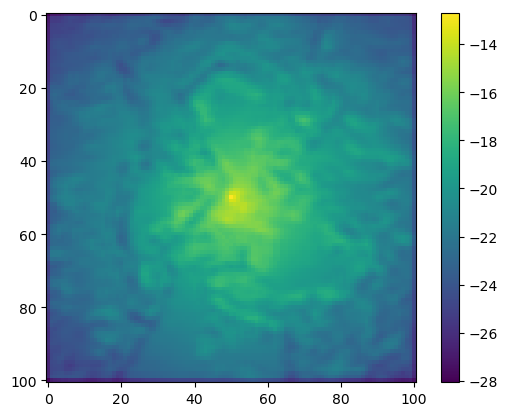

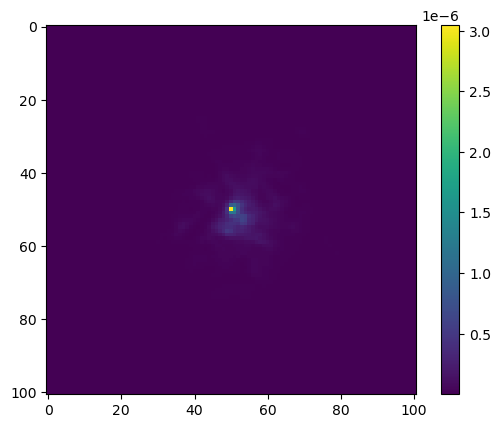

Sampled coordinates: (52, 39)
1172
1072
29300.0 -1432800.0
29300.0 -1432800.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


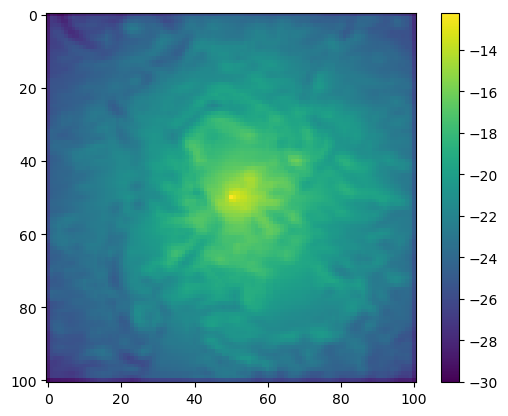

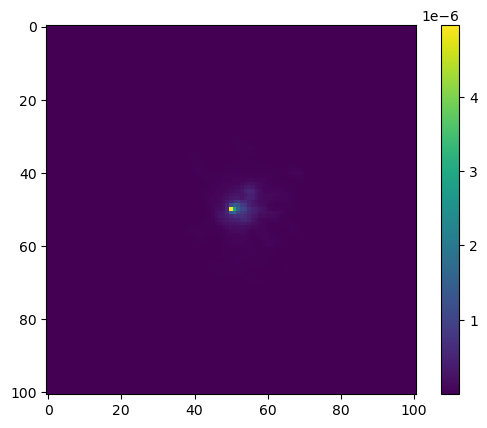

Sampled coordinates: (53, 49)
1175
1071
29375.0 -1432775.0
29375.0 -1432775.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


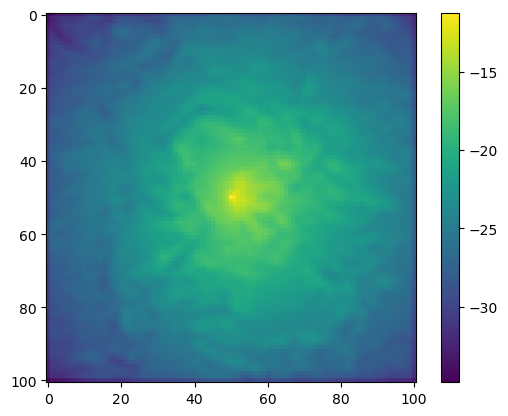

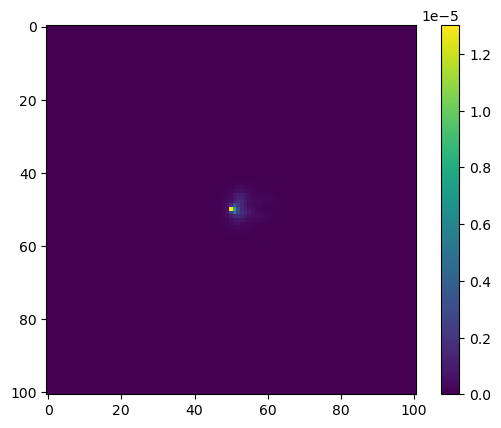

Sampled coordinates: (49, 55)
1174
1076
29350.0 -1432900.0
29350.0 -1432900.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


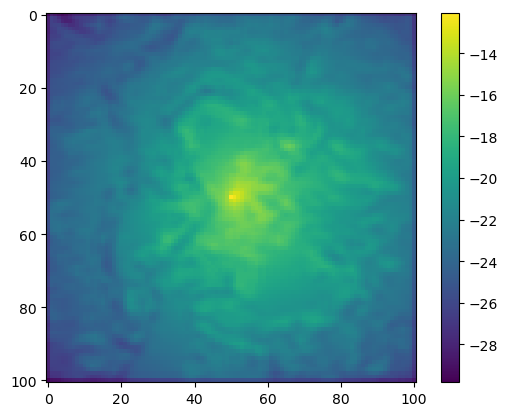

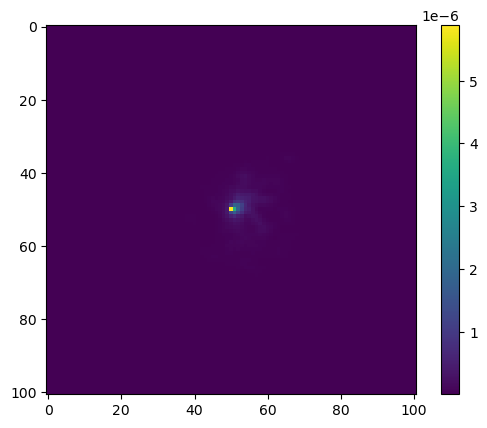

Sampled coordinates: (50, 52)
1174
1078
29350.0 -1432950.0
29350.0 -1432950.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


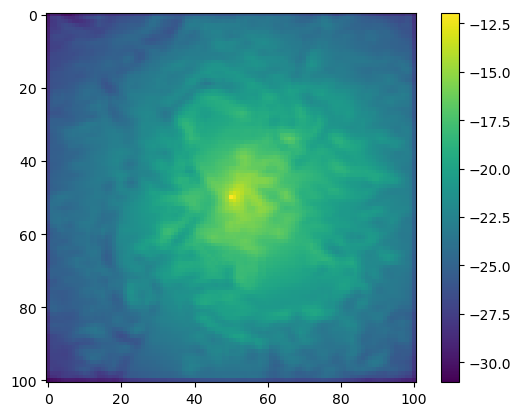

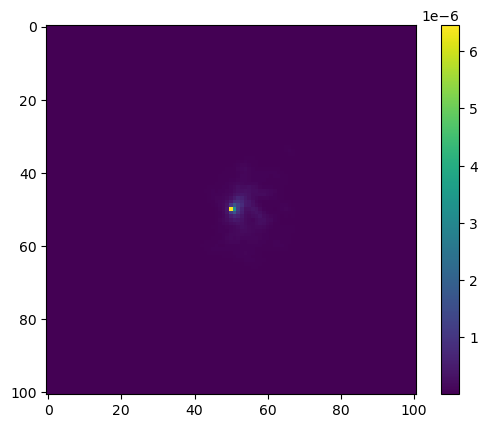

Sampled coordinates: (48, 54)
1172
1082
29300.0 -1433050.0
29300.0 -1433050.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


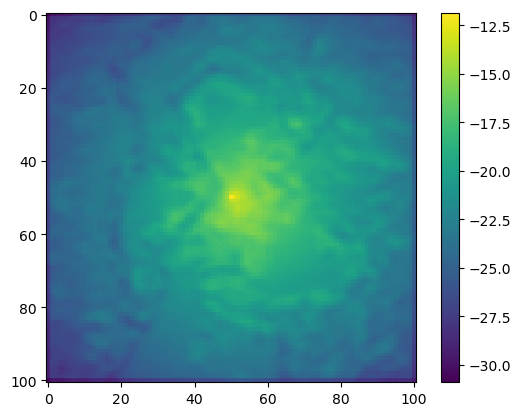

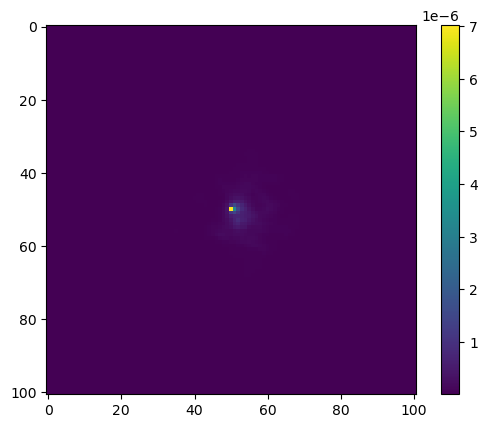

Sampled coordinates: (46, 53)
1168
1085
29200.0 -1433125.0
29200.0 -1433125.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


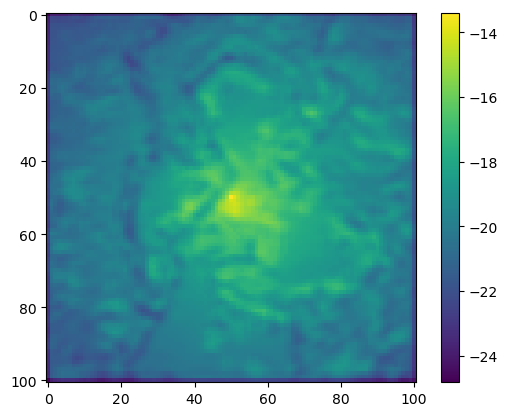

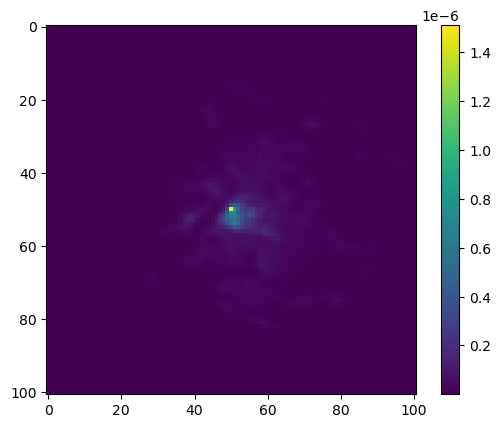

Sampled coordinates: (60, 78)
1178
1113
29450.0 -1433825.0
29450.0 -1433825.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


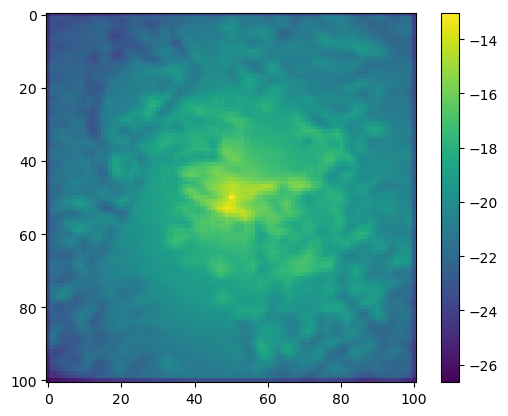

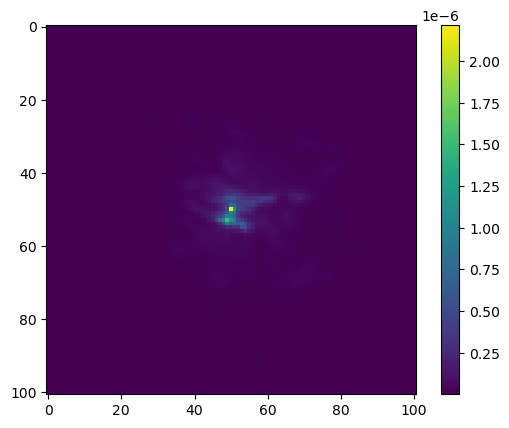

Sampled coordinates: (50, 53)
1178
1116
29450.0 -1433900.0
29450.0 -1433900.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


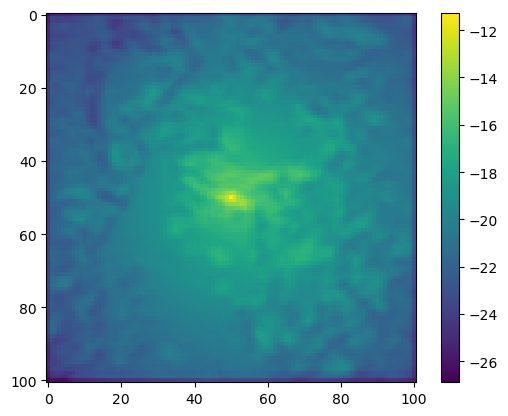

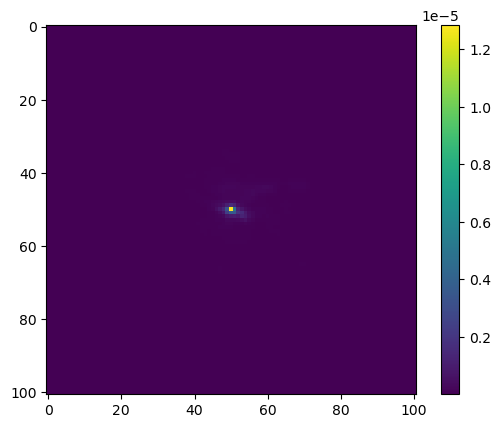

Sampled coordinates: (41, 42)
1169
1108
29225.0 -1433700.0
29225.0 -1433700.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


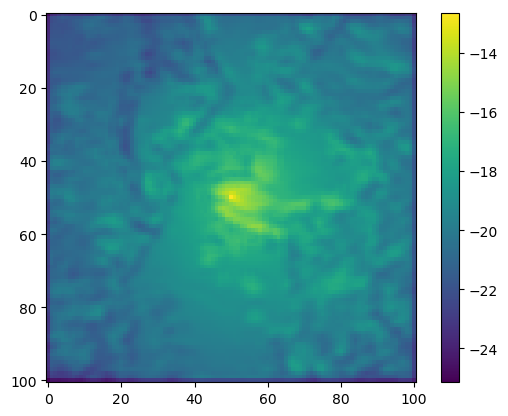

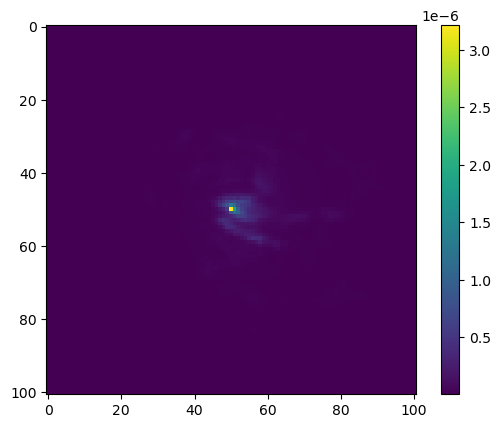

Sampled coordinates: (55, 49)
1174
1107
29350.0 -1433675.0
29350.0 -1433675.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


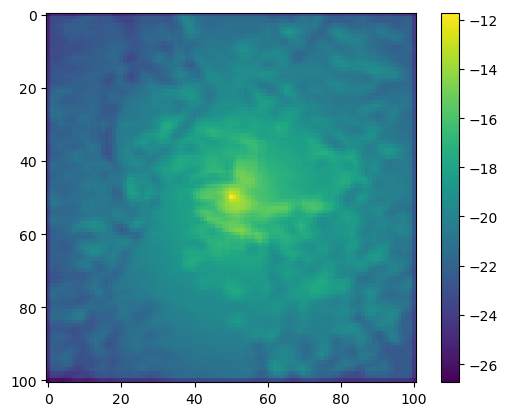

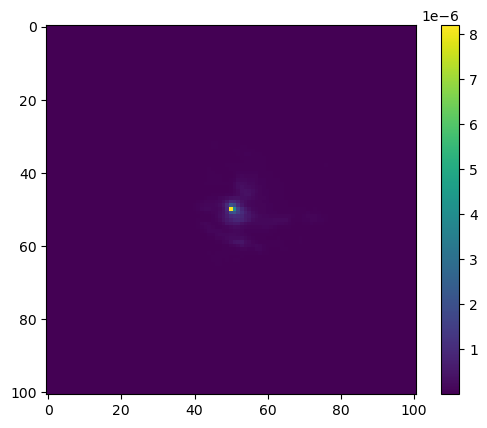

Sampled coordinates: (52, 61)
1176
1118
29400.0 -1433950.0
29400.0 -1433950.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


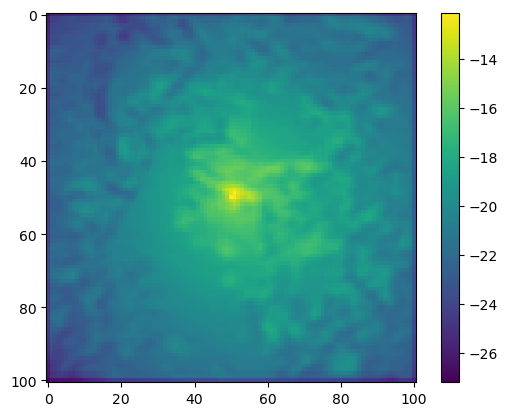

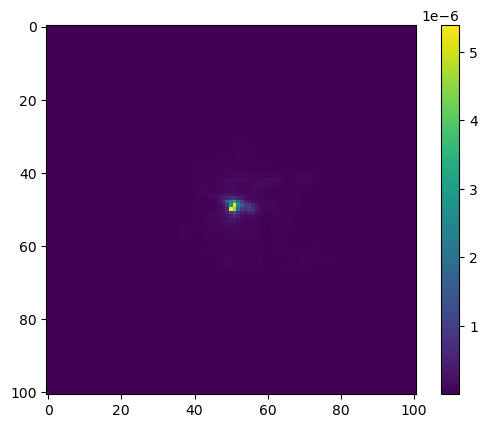

Sampled coordinates: (28, 39)
1154
1107
28850.0 -1433675.0
28850.0 -1433675.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


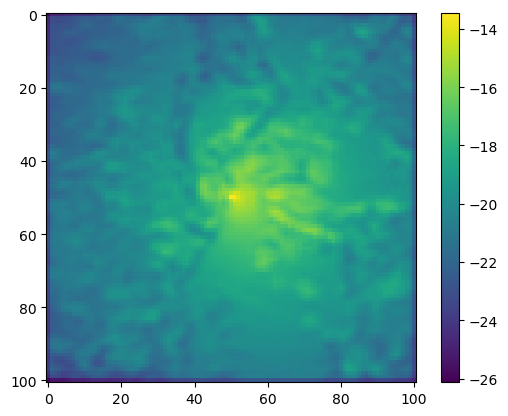

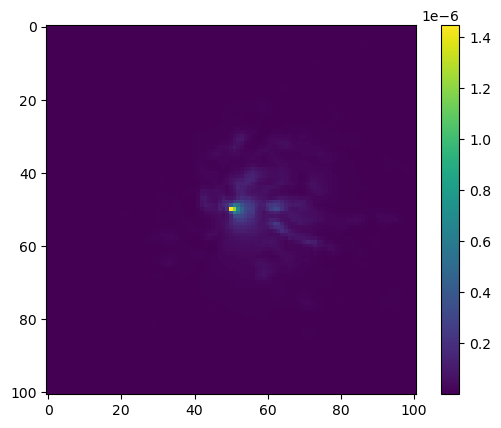

Sampled coordinates: (51, 50)
1155
1107
28875.0 -1433675.0
28875.0 -1433675.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


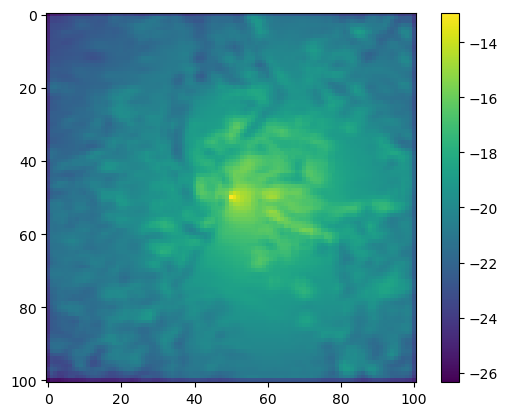

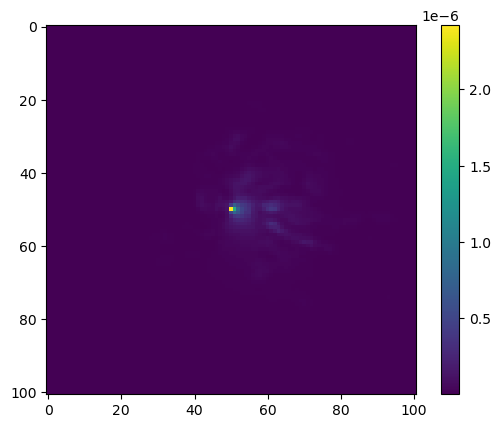

Sampled coordinates: (27, 51)
1132
1108
28300.0 -1433700.0
28300.0 -1433700.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


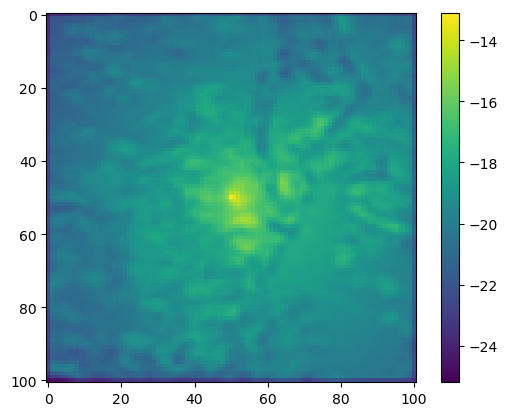

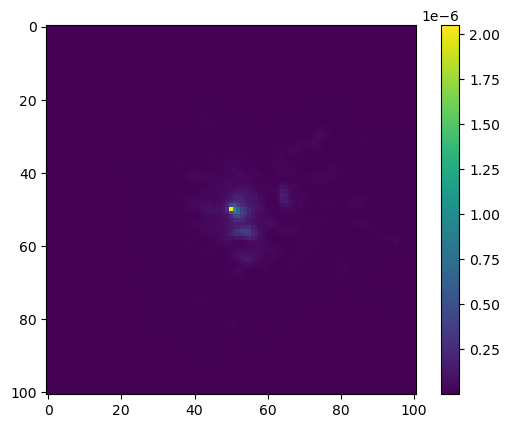

Sampled coordinates: (54, 59)
1136
1117
28400.0 -1433925.0
28400.0 -1433925.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


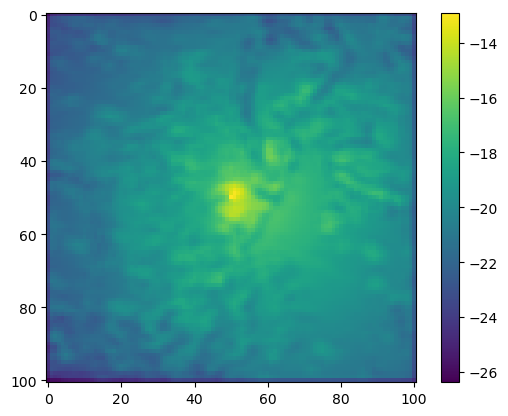

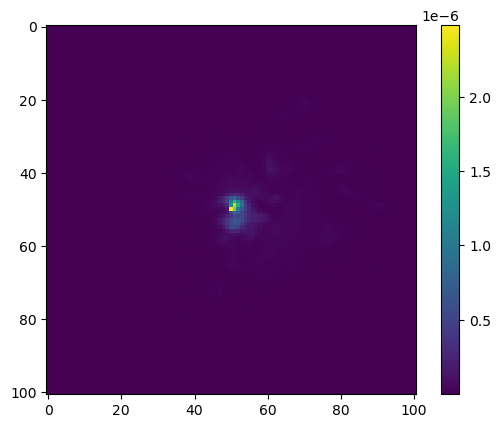

Sampled coordinates: (65, 78)
1151
1145
28775.0 -1434625.0
28775.0 -1434625.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


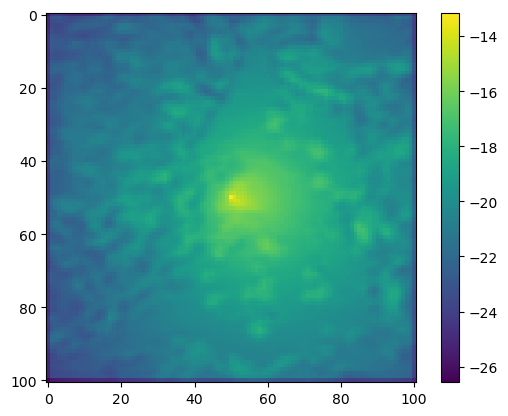

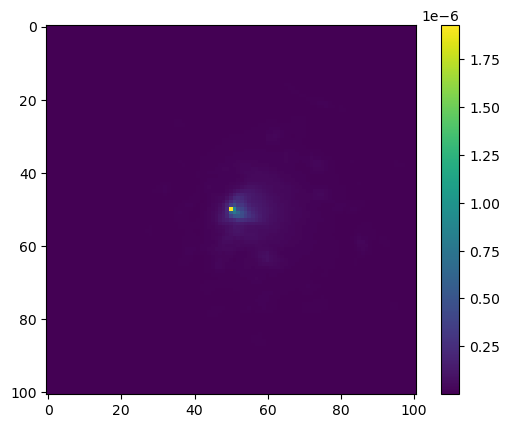

Sampled coordinates: (47, 55)
1148
1150
28700.0 -1434750.0
28700.0 -1434750.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


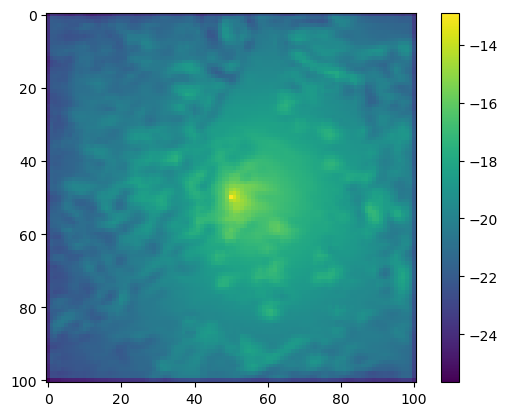

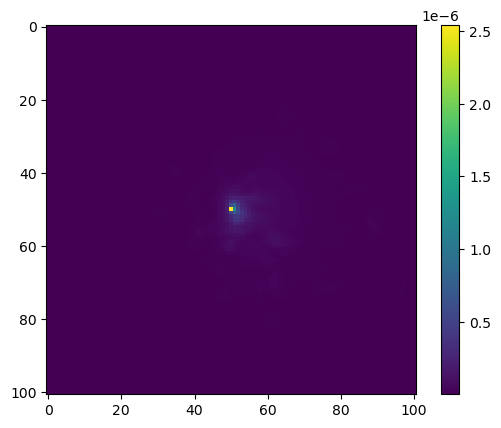

Sampled coordinates: (60, 53)
1158
1153
28950.0 -1434825.0
28950.0 -1434825.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


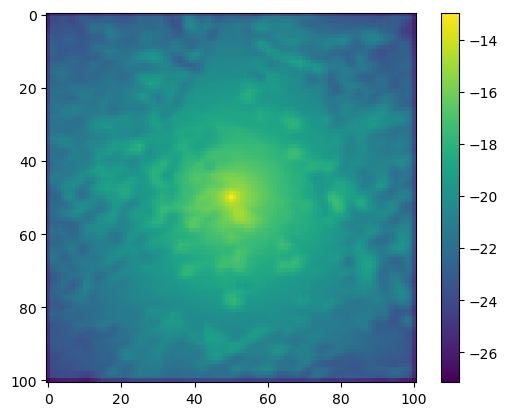

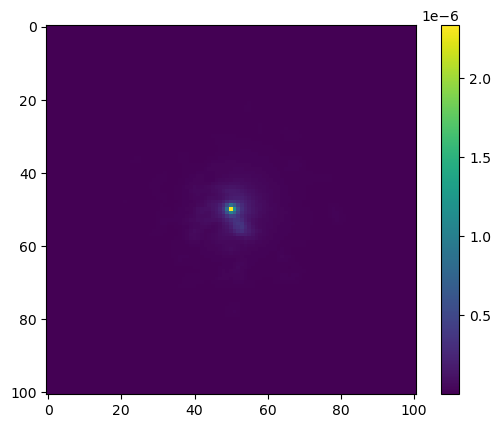

Sampled coordinates: (51, 41)
1159
1144
28975.0 -1434600.0
28975.0 -1434600.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


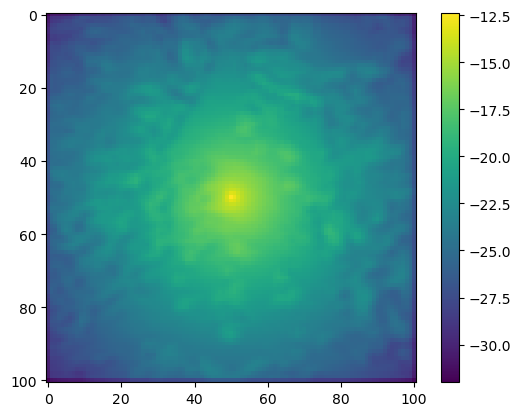

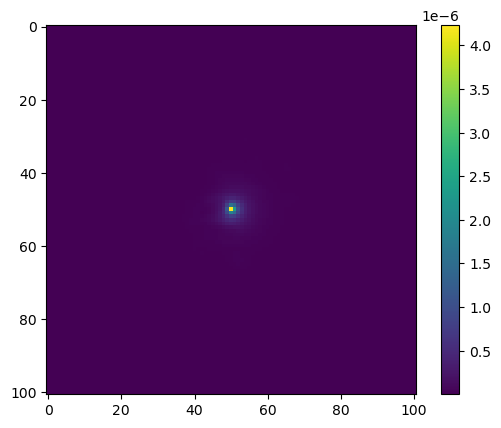

Sampled coordinates: (53, 55)
1162
1149
29050.0 -1434725.0
29050.0 -1434725.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


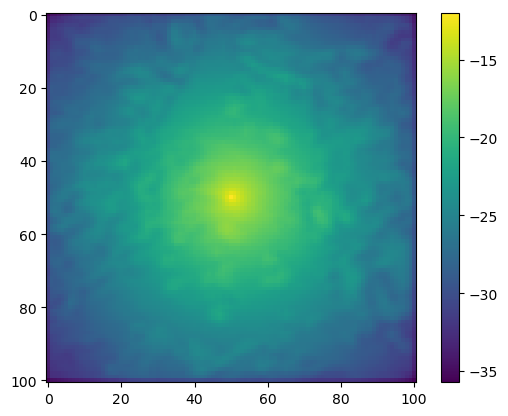

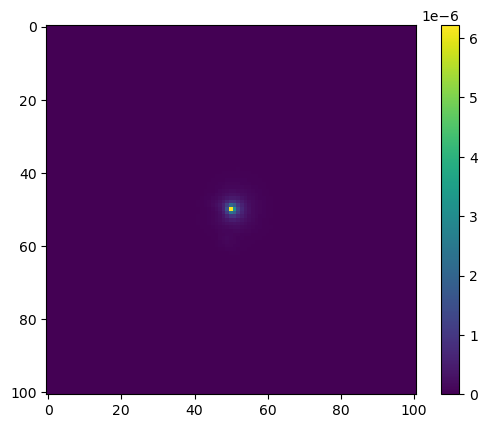

Sampled coordinates: (50, 50)
1162
1149
29050.0 -1434725.0
29050.0 -1434725.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


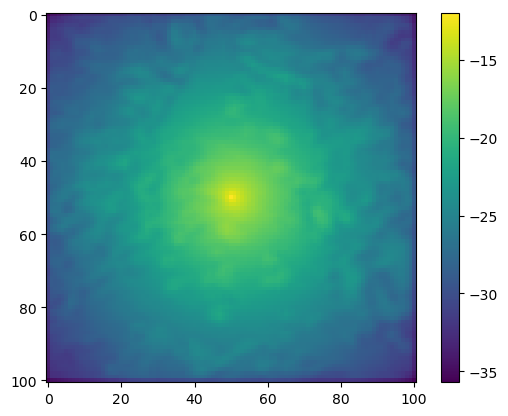

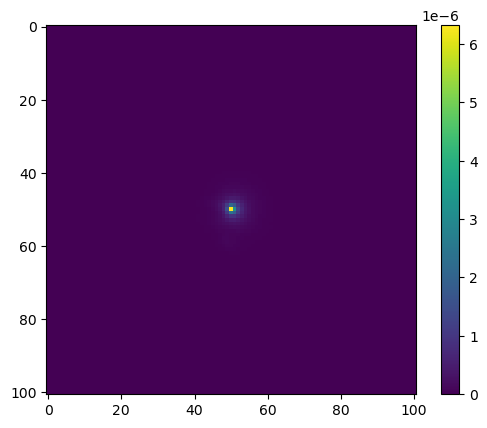

Sampled coordinates: (53, 50)
1165
1149
29125.0 -1434725.0
29125.0 -1434725.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


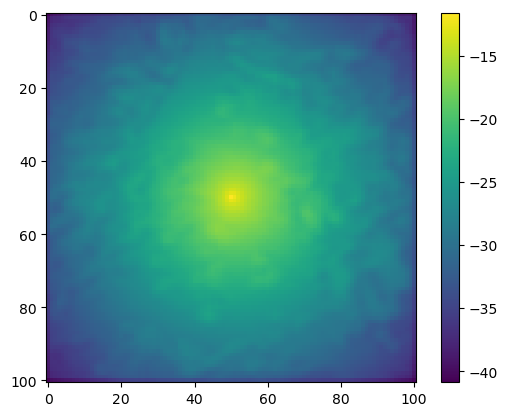

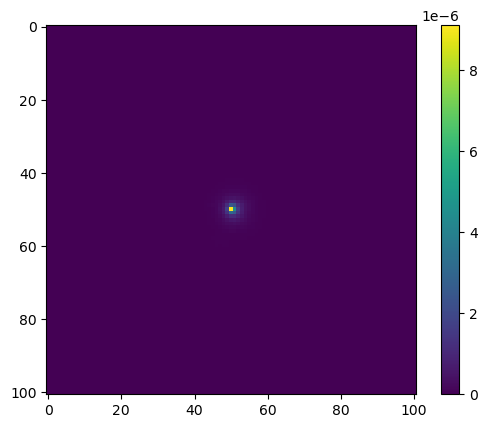

Sampled coordinates: (51, 48)
1166
1147
29150.0 -1434675.0
29150.0 -1434675.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


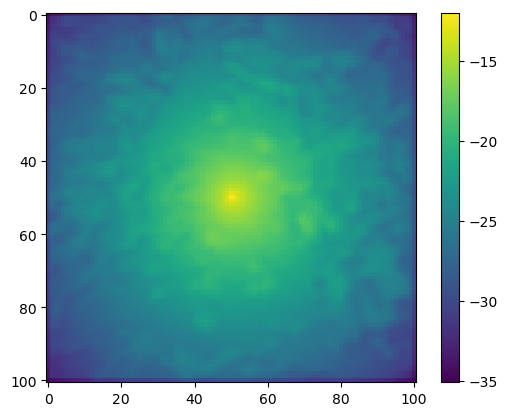

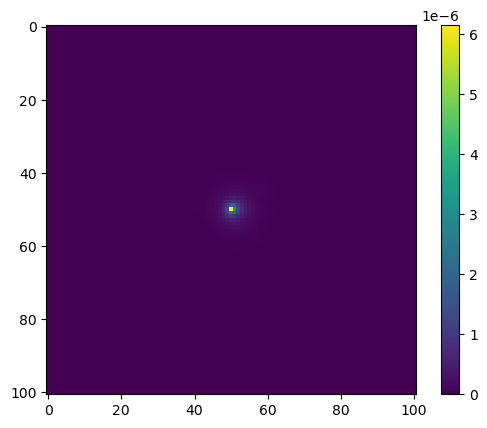

Sampled coordinates: (44, 38)
1160
1135
29000.0 -1434375.0
29000.0 -1434375.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


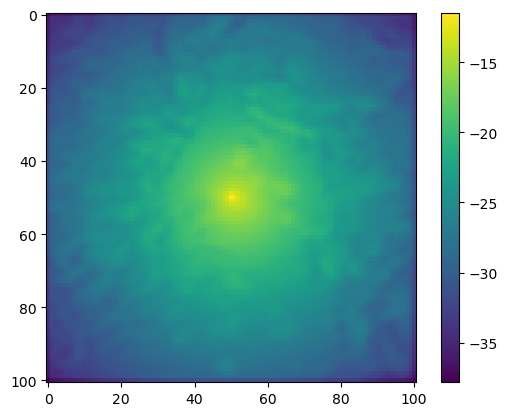

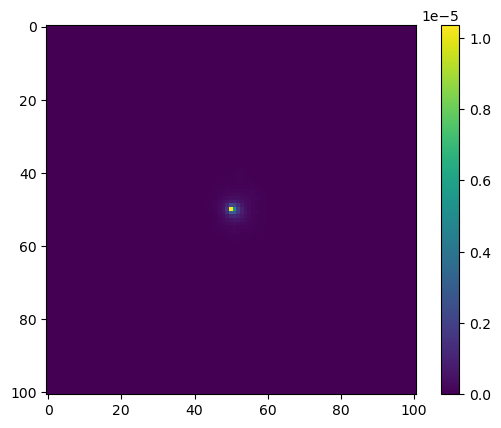

Sampled coordinates: (50, 50)
1160
1135
29000.0 -1434375.0
29000.0 -1434375.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


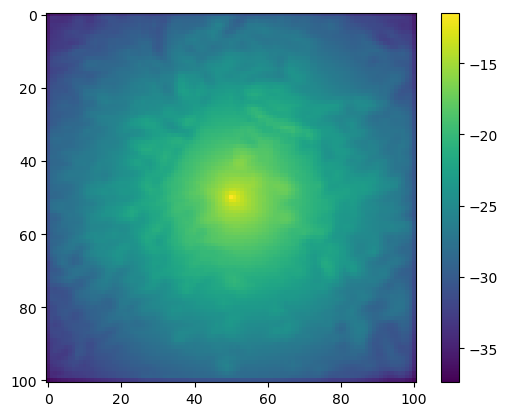

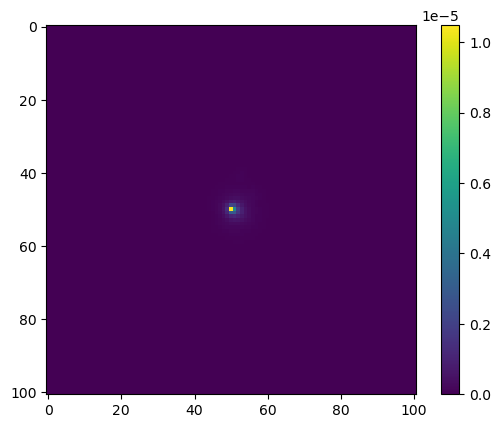

Sampled coordinates: (47, 52)
1157
1137
28925.0 -1434425.0
28925.0 -1434425.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


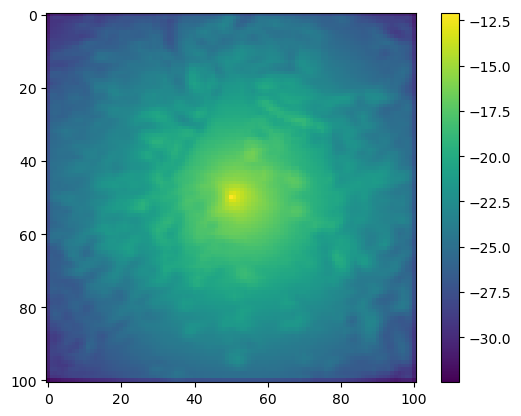

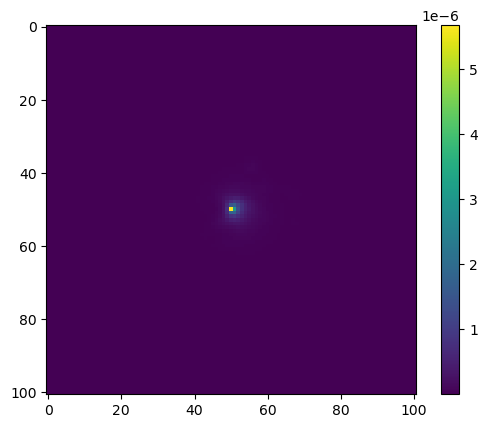

Sampled coordinates: (57, 47)
1164
1134
29100.0 -1434350.0
29100.0 -1434350.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


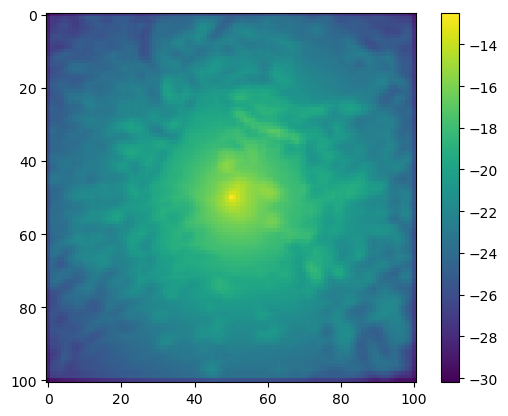

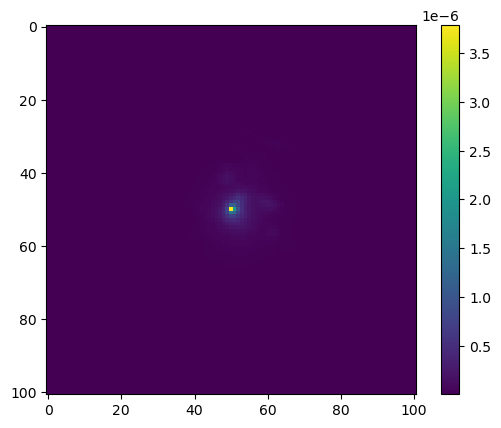

Sampled coordinates: (50, 50)
1164
1134
29100.0 -1434350.0
29100.0 -1434350.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


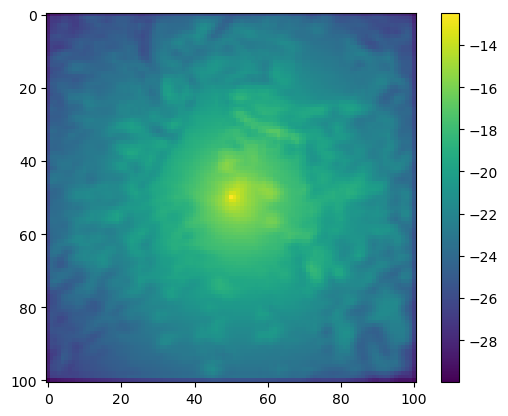

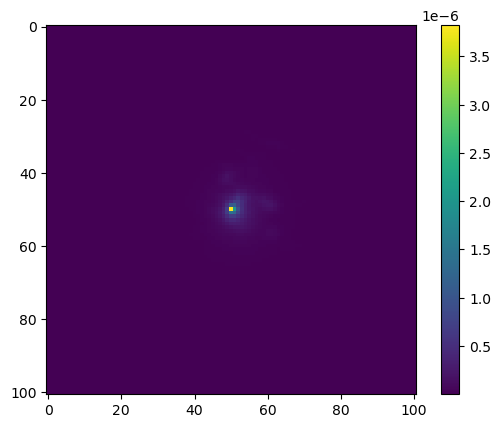

Sampled coordinates: (60, 47)
1174
1131
29350.0 -1434275.0
29350.0 -1434275.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


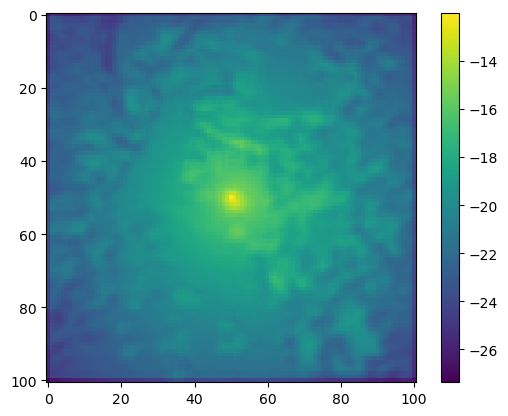

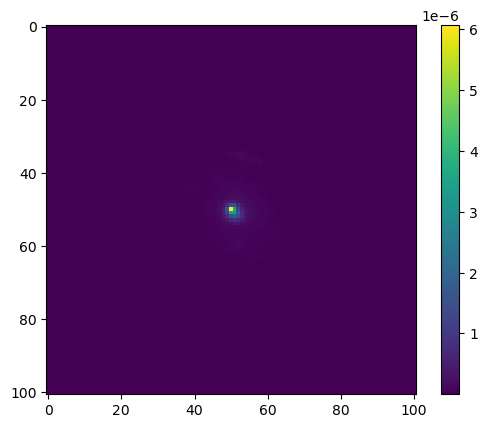

Sampled coordinates: (61, 35)
1185
1116
29625.0 -1433900.0
29625.0 -1433900.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


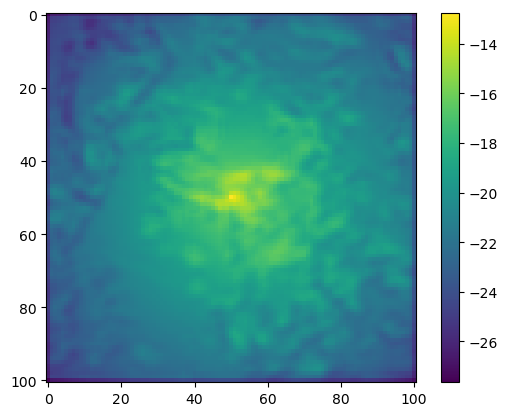

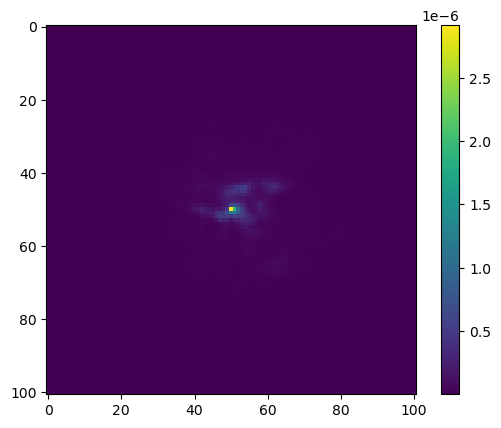

Sampled coordinates: (38, 47)
1173
1113
29325.0 -1433825.0
29325.0 -1433825.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


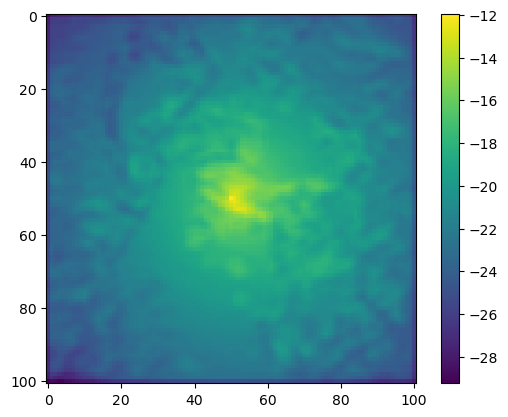

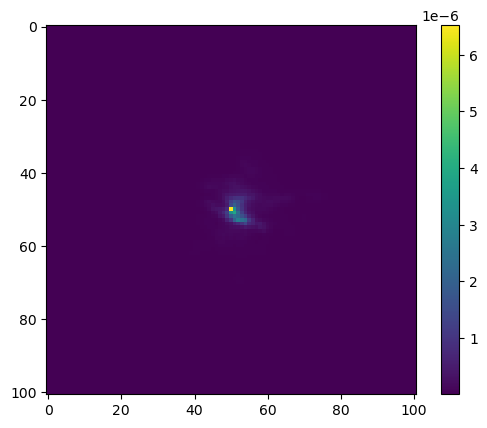

Sampled coordinates: (53, 53)
1176
1116
29400.0 -1433900.0
29400.0 -1433900.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


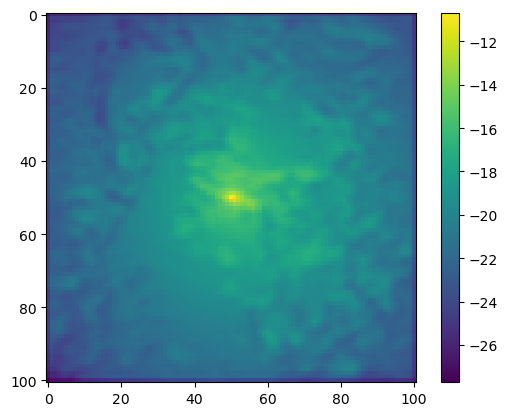

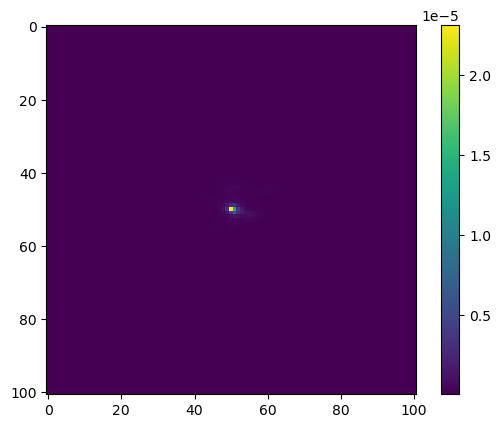

Sampled coordinates: (50, 60)
1176
1126
29400.0 -1434150.0
29400.0 -1434150.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


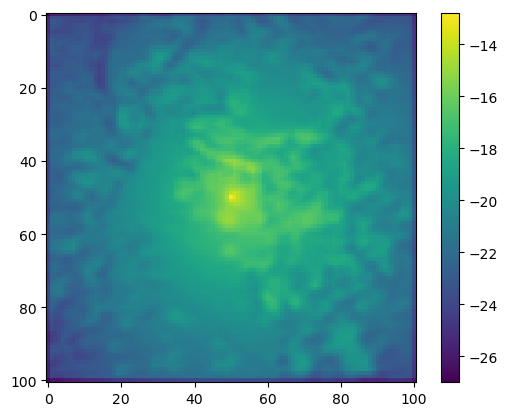

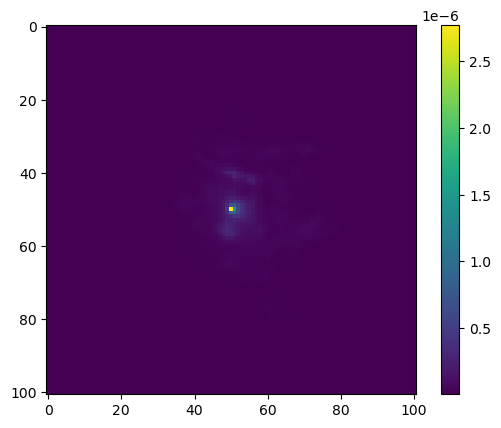

Sampled coordinates: (29, 44)
1155
1120
28875.0 -1434000.0
28875.0 -1434000.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


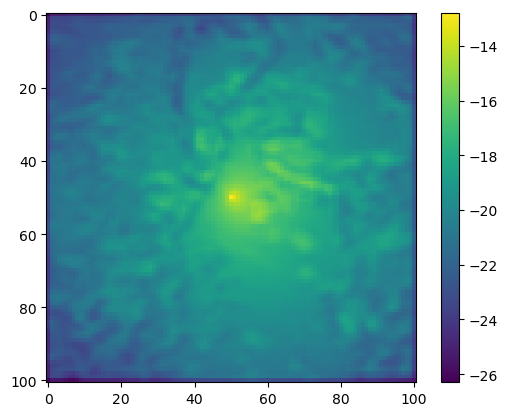

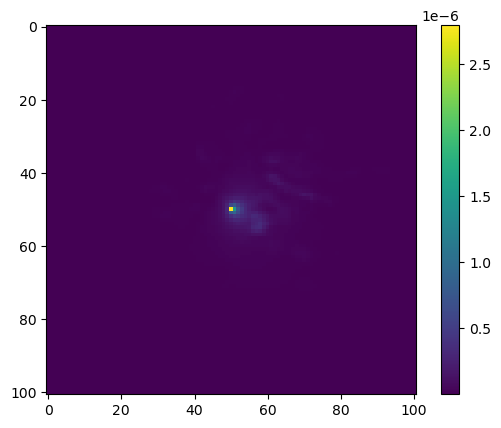

Sampled coordinates: (41, 60)
1146
1130
28650.0 -1434250.0
28650.0 -1434250.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


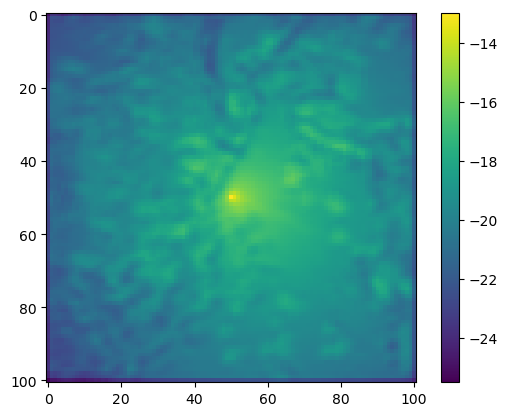

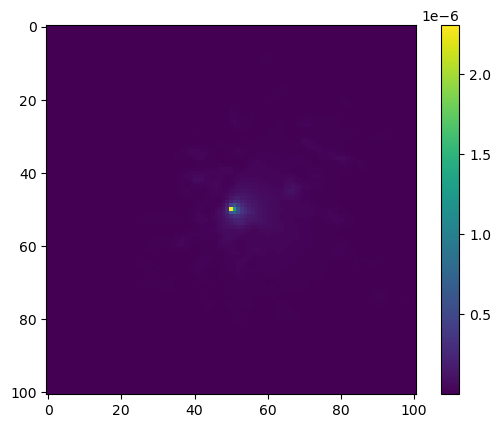

Sampled coordinates: (57, 81)
1153
1161
28825.0 -1435025.0
28825.0 -1435025.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


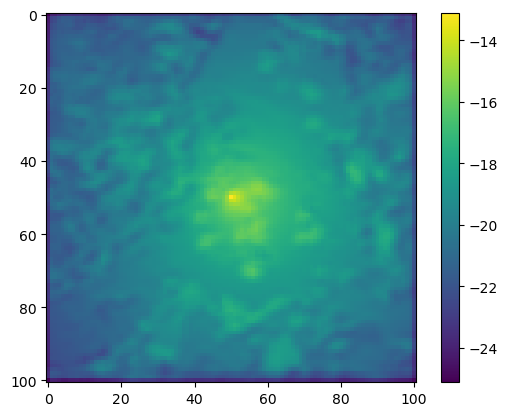

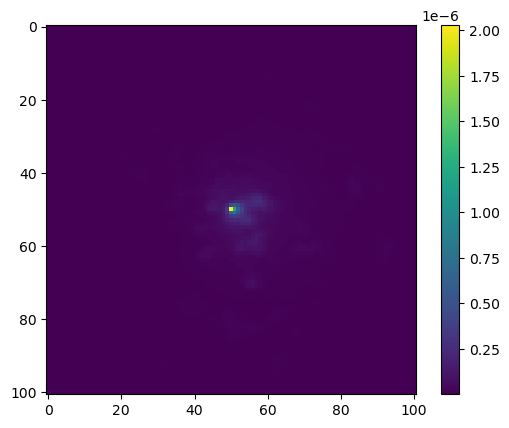

Sampled coordinates: (67, 63)
1170
1174
29250.0 -1435350.0
29250.0 -1435350.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


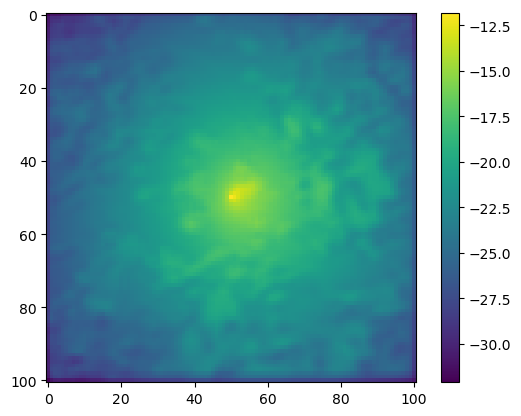

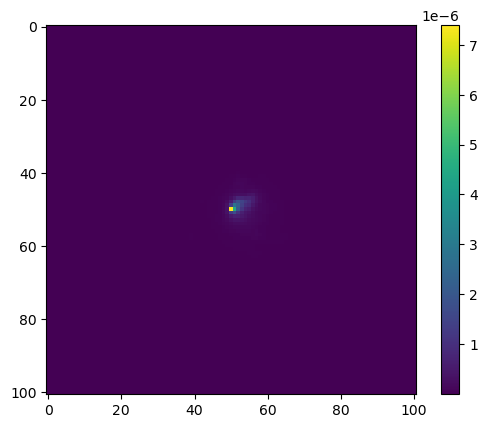

Sampled coordinates: (68, 37)
1188
1161
29700.0 -1435025.0
29700.0 -1435025.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


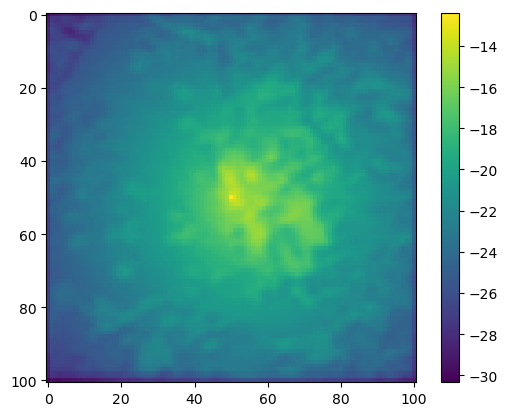

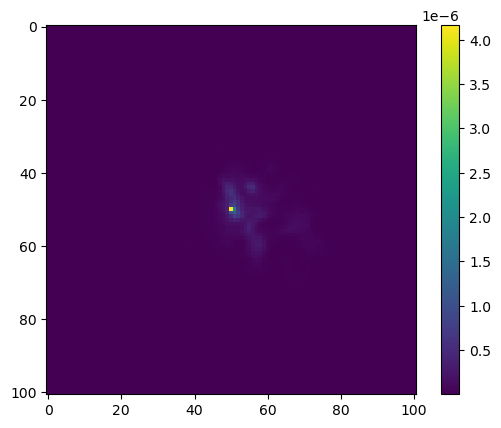

Sampled coordinates: (58, 48)
1196
1159
29900.0 -1434975.0
29900.0 -1434975.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


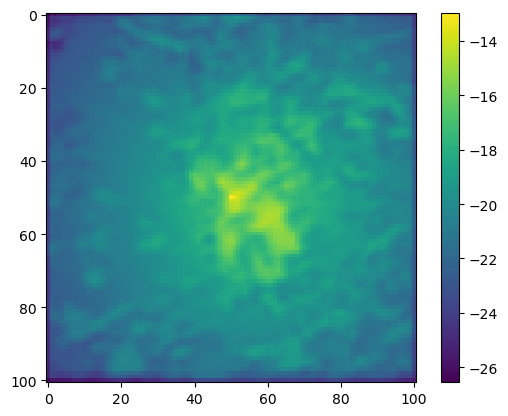

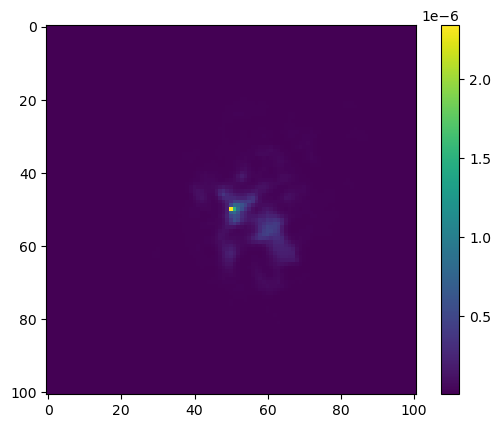

Sampled coordinates: (53, 61)
1199
1170
29975.0 -1435250.0
29975.0 -1435250.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


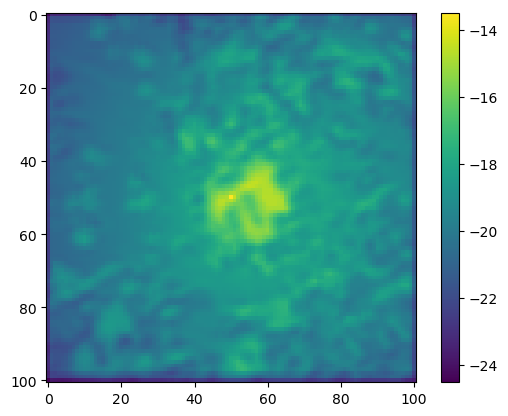

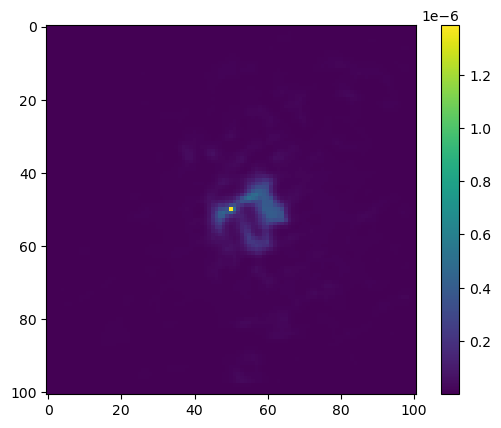

Sampled coordinates: (48, 45)
1197
1165
29925.0 -1435125.0
29925.0 -1435125.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


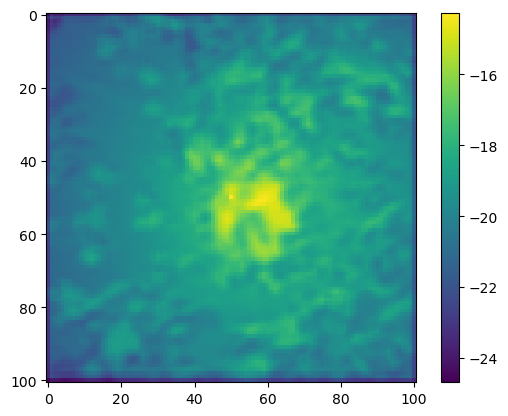

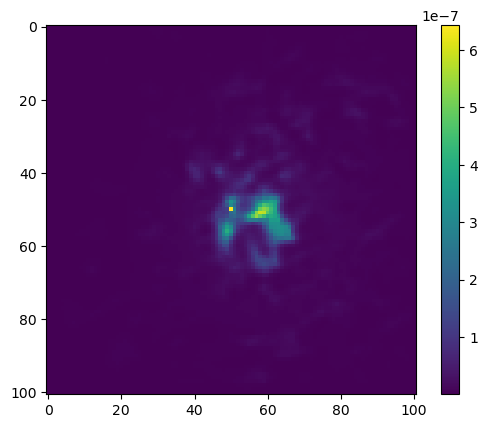

Sampled coordinates: (56, 63)
1203
1178
30075.0 -1435450.0
30075.0 -1435450.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


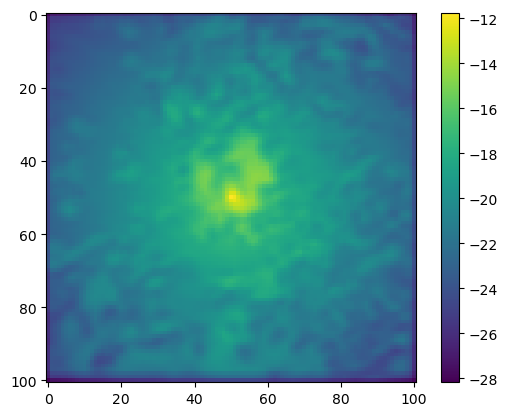

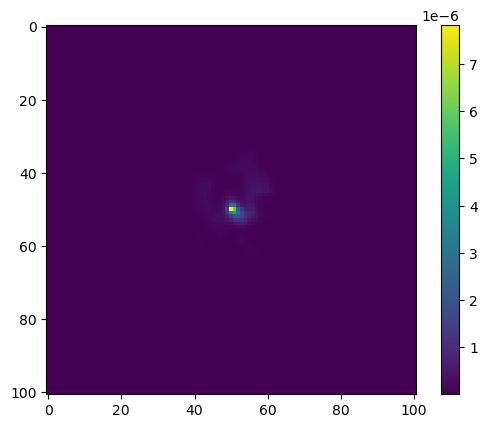

Sampled coordinates: (52, 54)
1205
1182
30125.0 -1435550.0
30125.0 -1435550.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


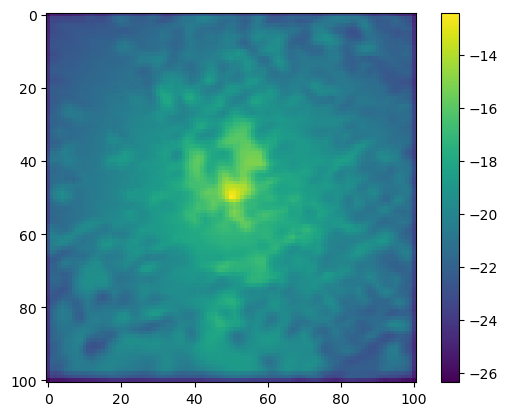

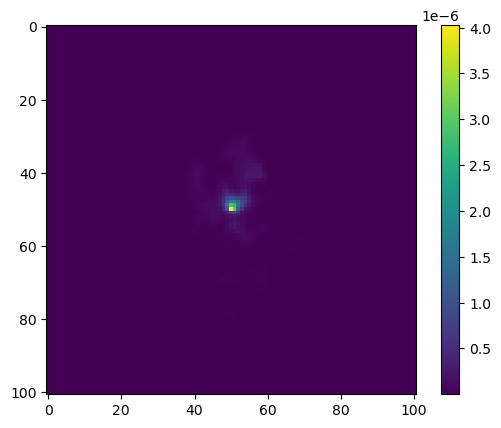

Sampled coordinates: (41, 52)
1196
1184
29900.0 -1435600.0
29900.0 -1435600.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


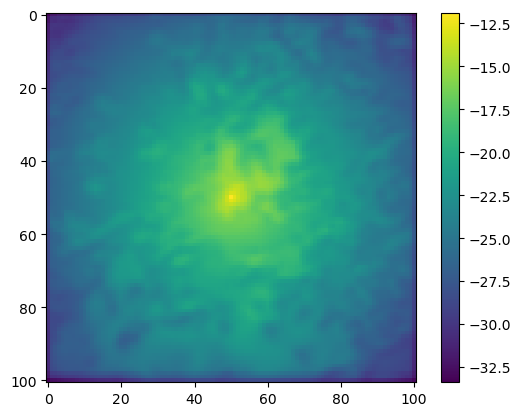

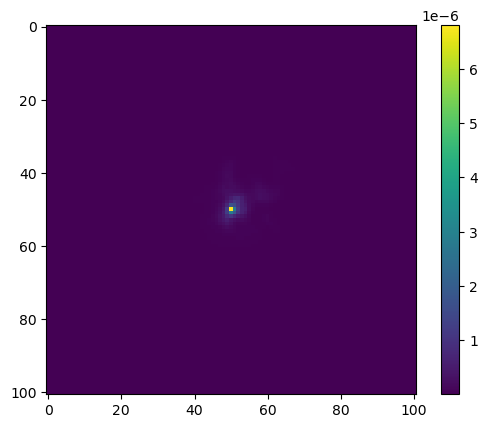

Sampled coordinates: (48, 50)
1194
1184
29850.0 -1435600.0
29850.0 -1435600.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


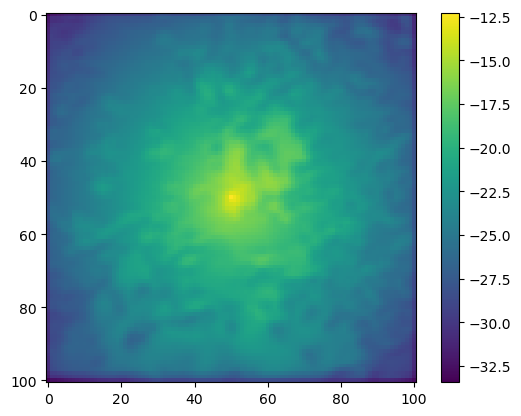

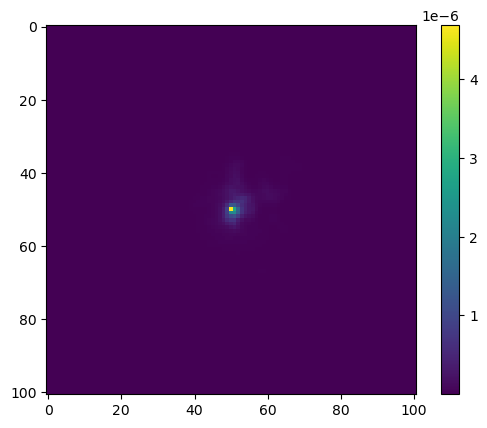

Sampled coordinates: (52, 52)
1196
1186
29900.0 -1435650.0
29900.0 -1435650.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


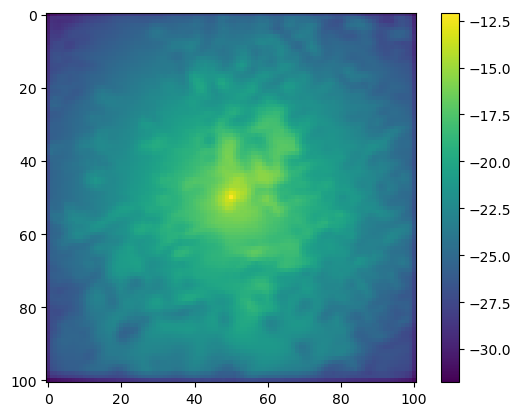

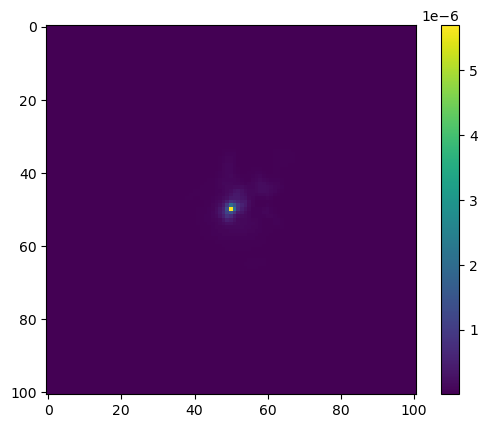

Sampled coordinates: (61, 48)
1207
1184
30175.0 -1435600.0
30175.0 -1435600.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


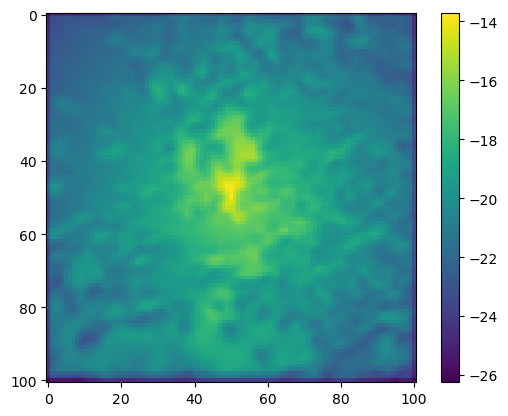

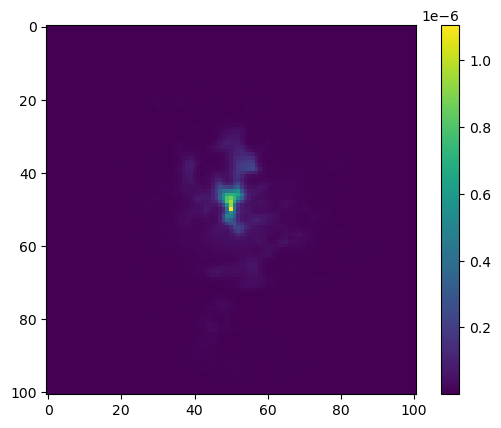

Sampled coordinates: (46, 50)
1203
1184
30075.0 -1435600.0
30075.0 -1435600.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


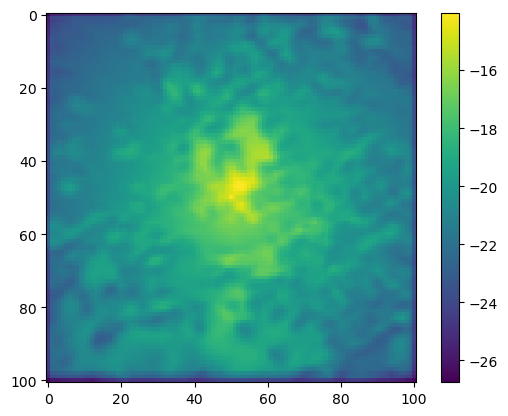

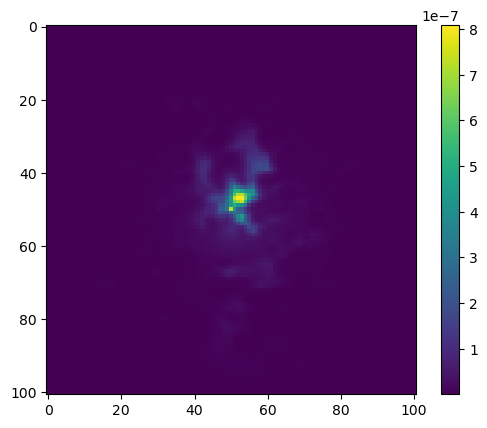

Sampled coordinates: (66, 58)
1219
1192
30475.0 -1435800.0
30475.0 -1435800.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


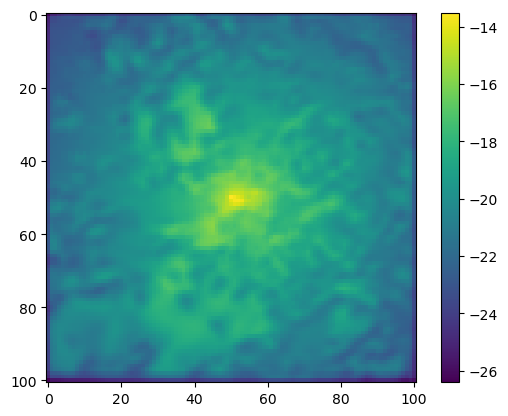

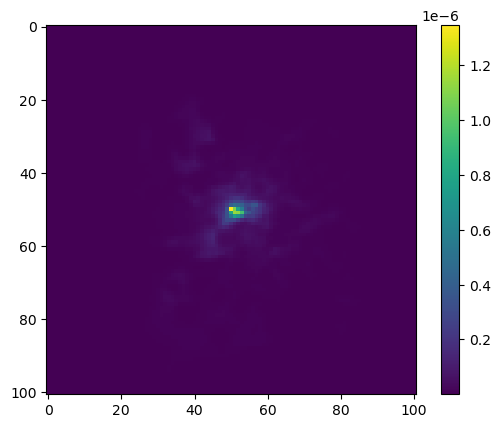

Sampled coordinates: (42, 30)
1211
1172
30275.0 -1435300.0
30275.0 -1435300.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


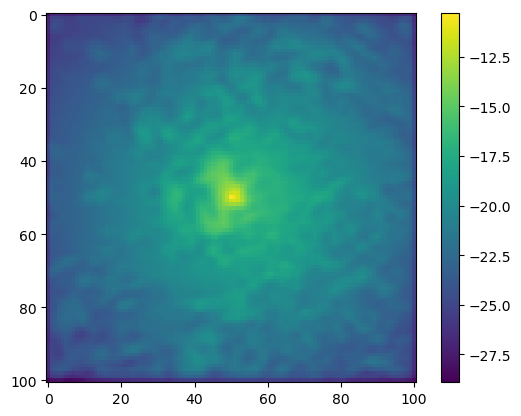

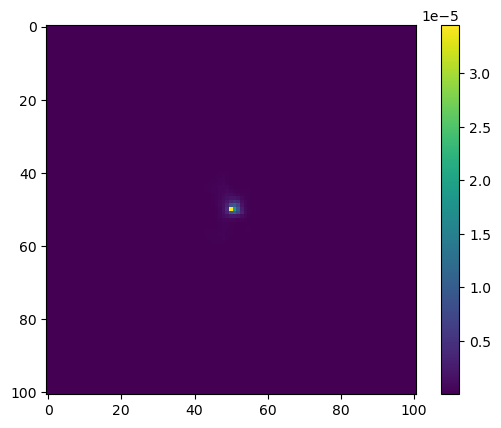

Sampled coordinates: (50, 50)
1211
1172
30275.0 -1435300.0
30275.0 -1435300.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


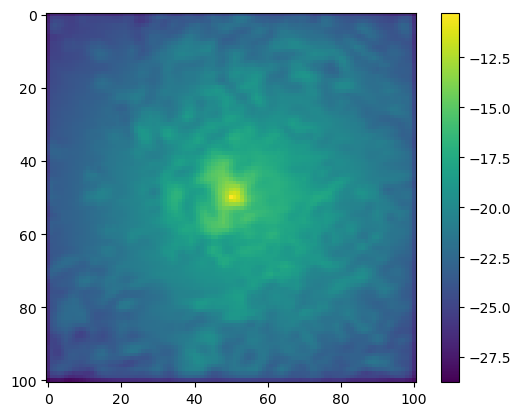

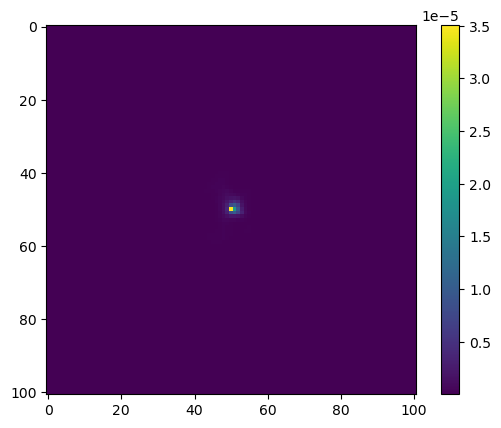

Sampled coordinates: (51, 51)
1212
1173
30300.0 -1435325.0
30300.0 -1435325.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


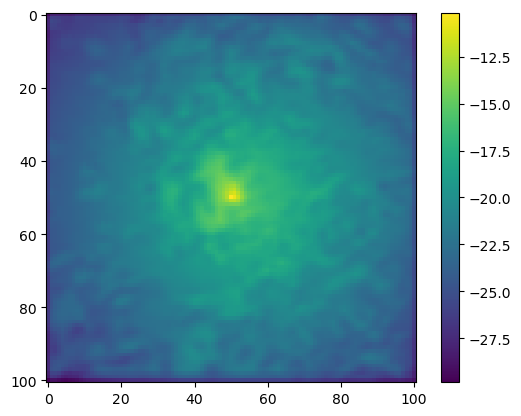

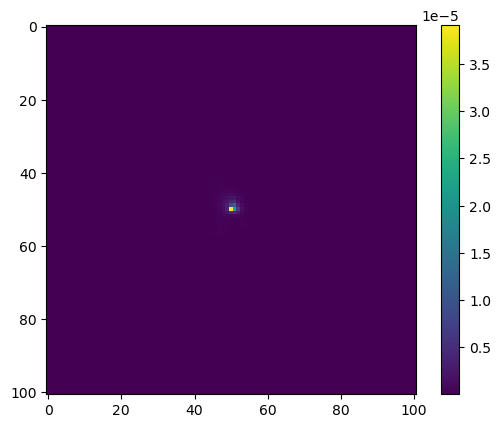

Sampled coordinates: (48, 50)
1210
1173
30250.0 -1435325.0
30250.0 -1435325.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


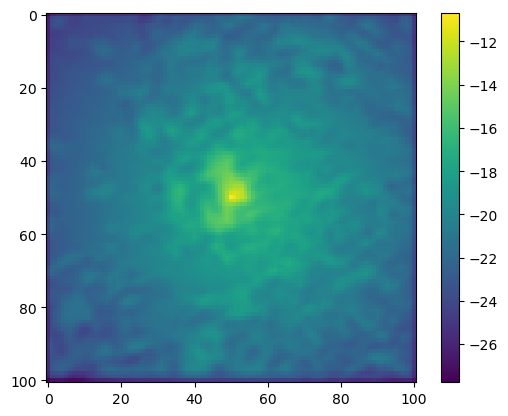

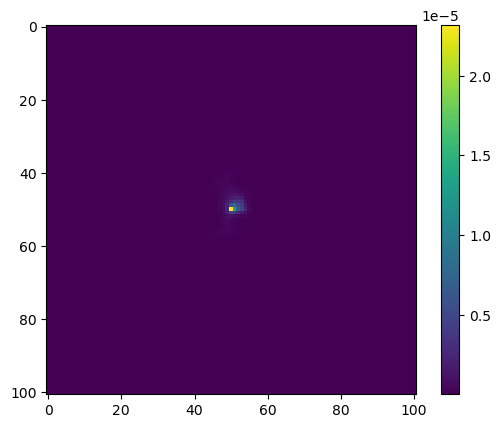

Sampled coordinates: (51, 52)
1211
1175
30275.0 -1435375.0
30275.0 -1435375.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


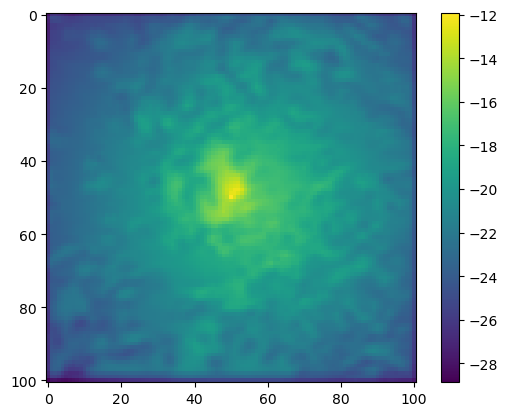

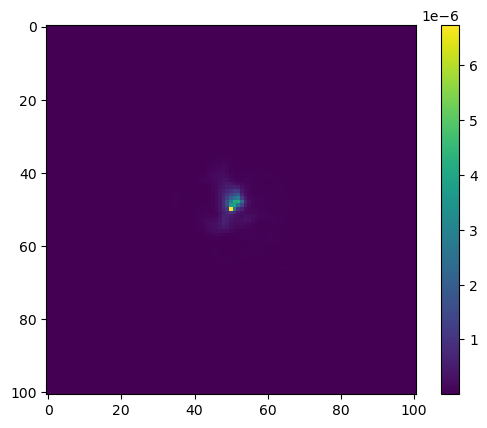

Sampled coordinates: (55, 50)
1216
1175
30400.0 -1435375.0
30400.0 -1435375.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


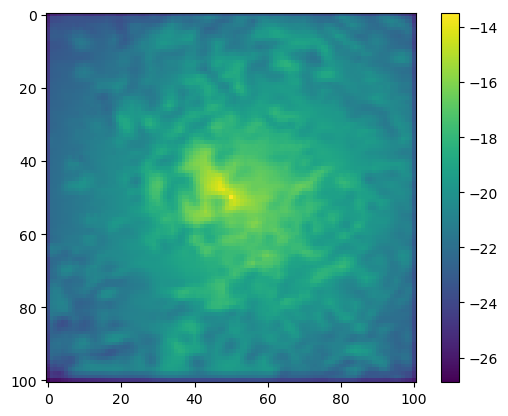

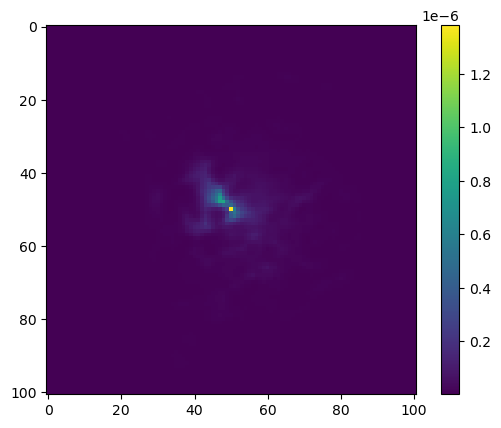

Sampled coordinates: (57, 70)
1223
1195
30575.0 -1435875.0
30575.0 -1435875.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


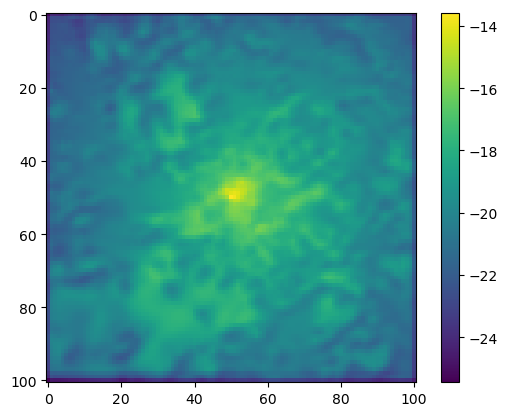

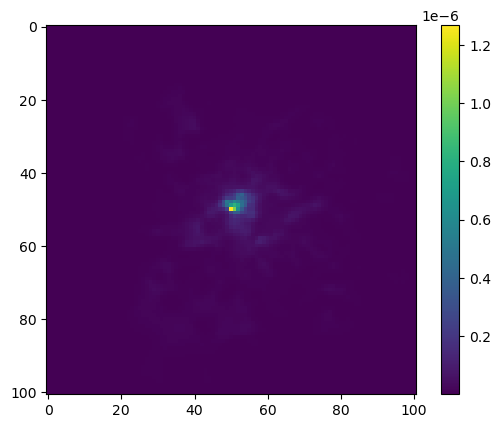

Sampled coordinates: (60, 60)
1233
1205
30825.0 -1436125.0
30825.0 -1436125.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


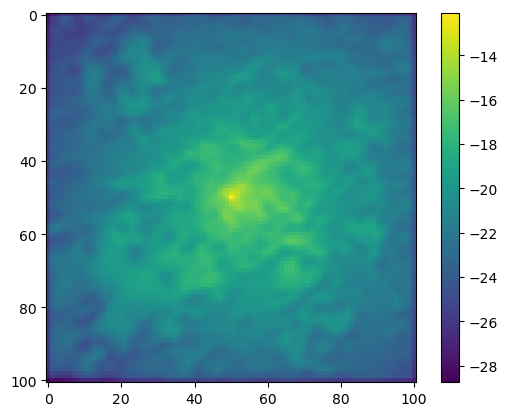

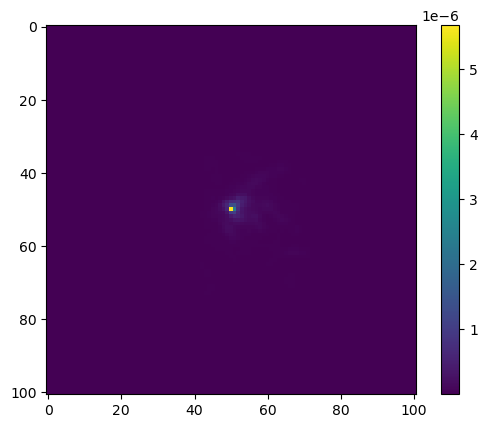

Sampled coordinates: (43, 54)
1226
1209
30650.0 -1436225.0
30650.0 -1436225.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


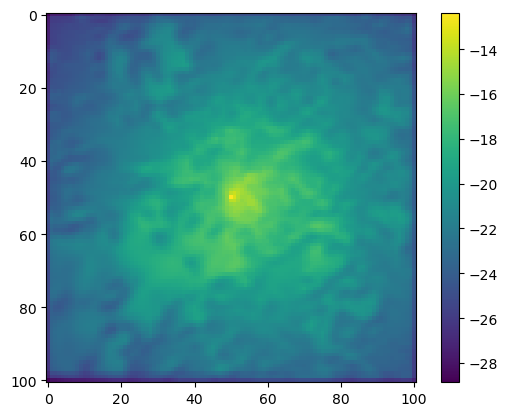

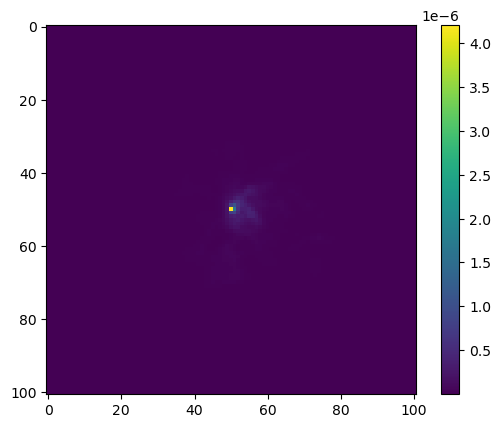

Sampled coordinates: (42, 29)
1218
1188
30450.0 -1435700.0
30450.0 -1435700.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


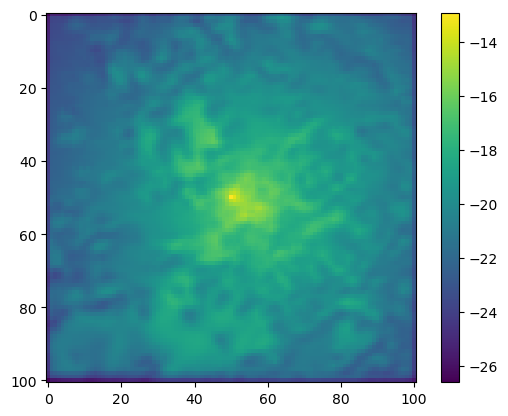

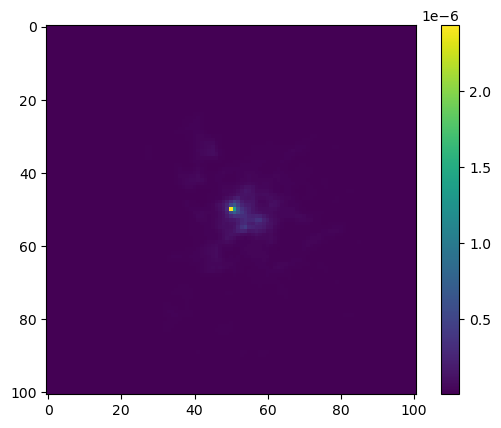

Sampled coordinates: (49, 53)
1217
1191
30425.0 -1435775.0
30425.0 -1435775.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


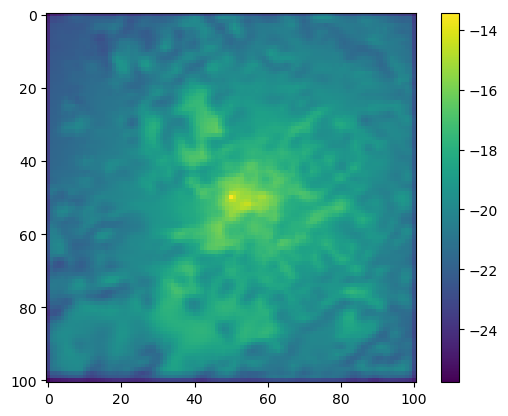

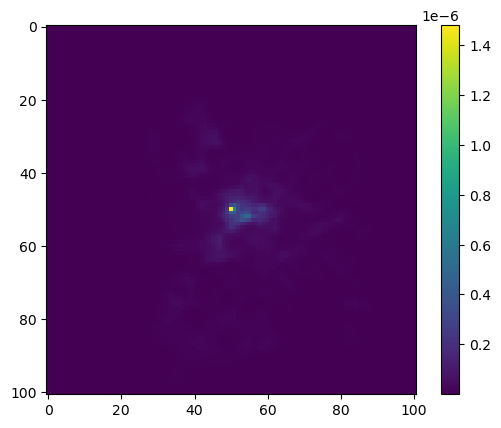

Sampled coordinates: (57, 64)
1224
1205
30600.0 -1436125.0
30600.0 -1436125.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


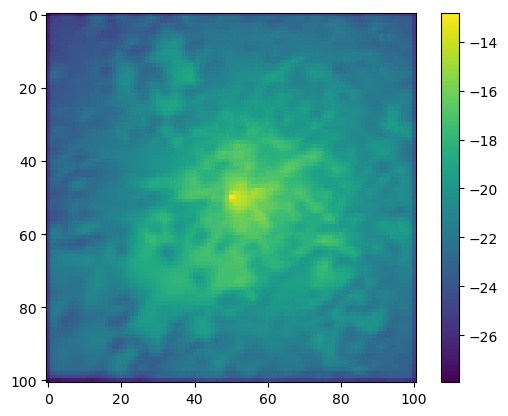

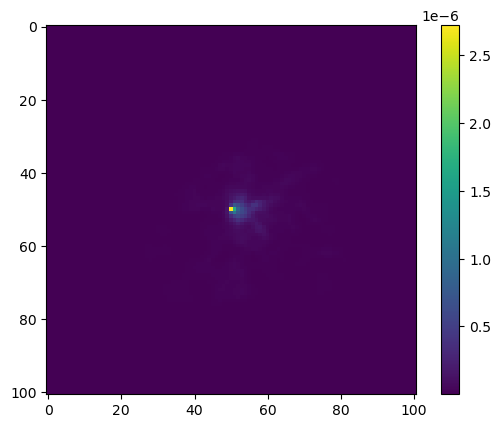

Sampled coordinates: (50, 57)
1224
1212
30600.0 -1436300.0
30600.0 -1436300.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


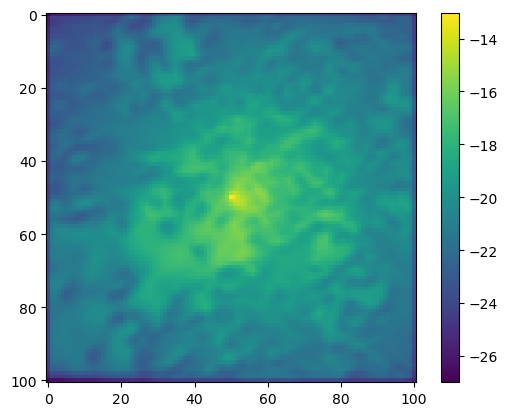

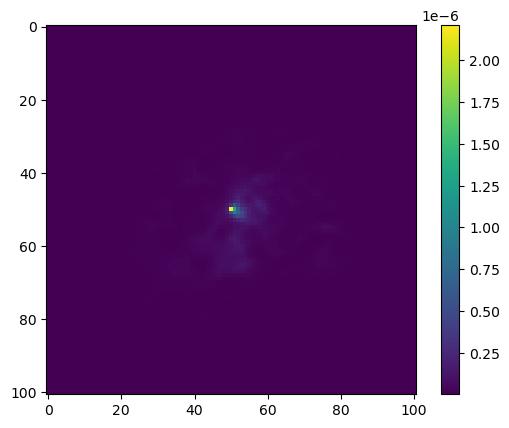

Sampled coordinates: (45, 54)
1219
1216
30475.0 -1436400.0
30475.0 -1436400.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


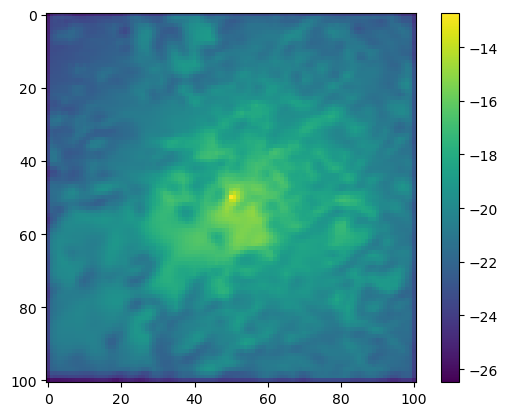

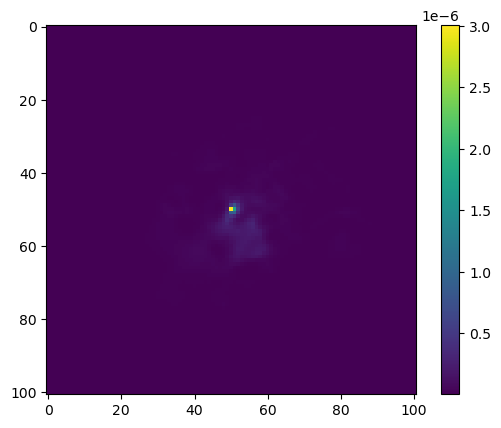

Sampled coordinates: (60, 33)
1229
1199
30725.0 -1435975.0
30725.0 -1435975.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


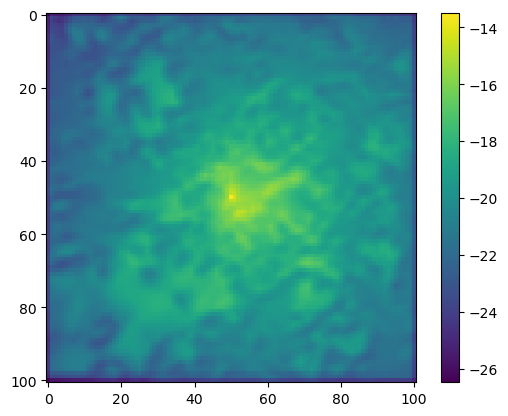

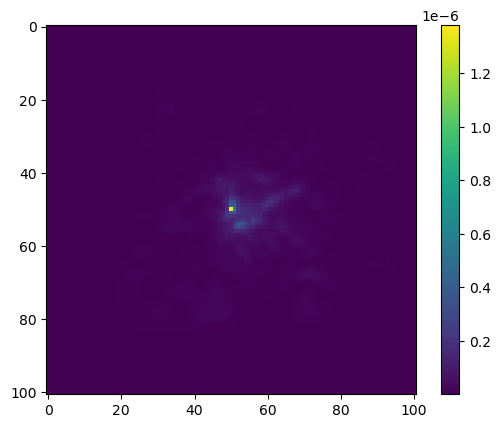

Sampled coordinates: (21, 92)
1200
1241
30000.0 -1437025.0
30000.0 -1437025.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


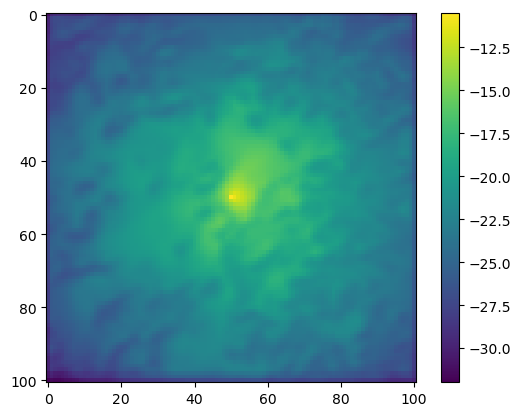

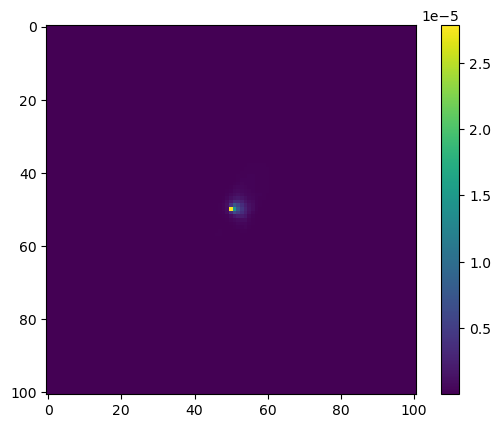

Sampled coordinates: (51, 51)
1201
1242
30025.0 -1437050.0
30025.0 -1437050.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


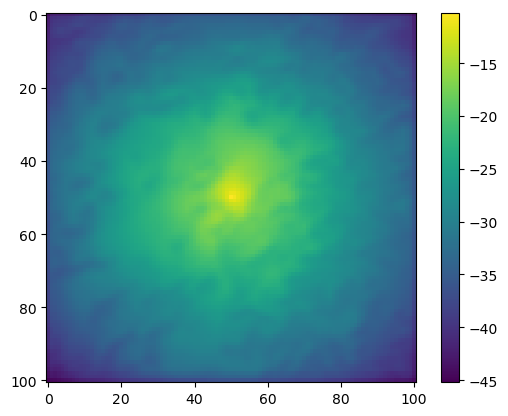

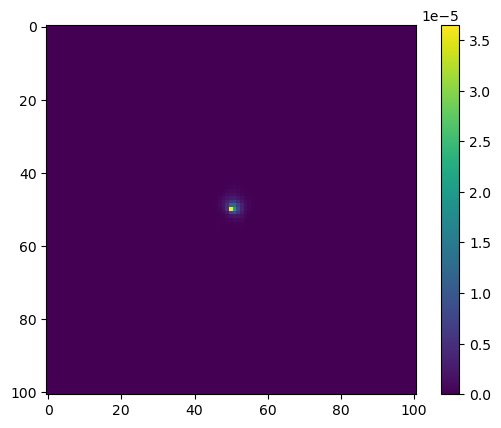

Sampled coordinates: (49, 50)
1200
1242
30000.0 -1437050.0
30000.0 -1437050.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


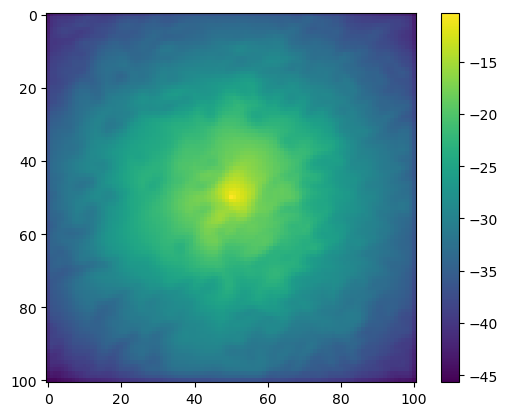

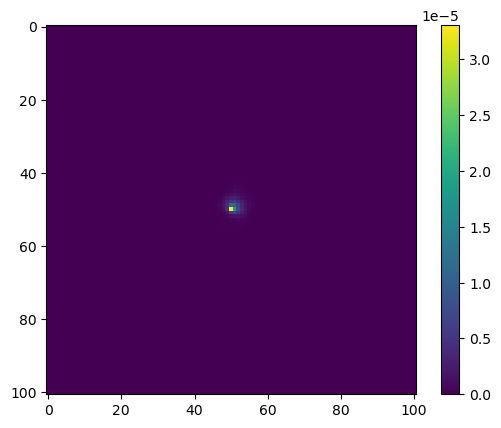

Sampled coordinates: (49, 51)
1199
1243
29975.0 -1437075.0
29975.0 -1437075.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


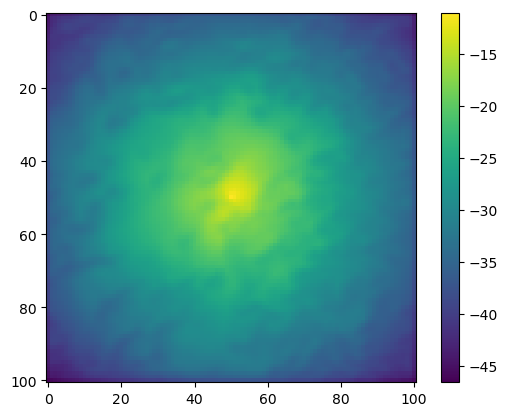

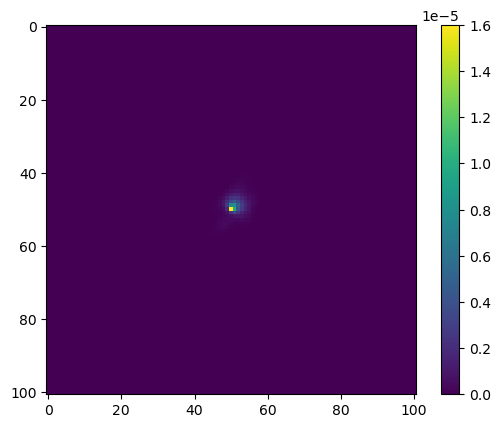

Sampled coordinates: (51, 51)
1200
1244
30000.0 -1437100.0
30000.0 -1437100.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


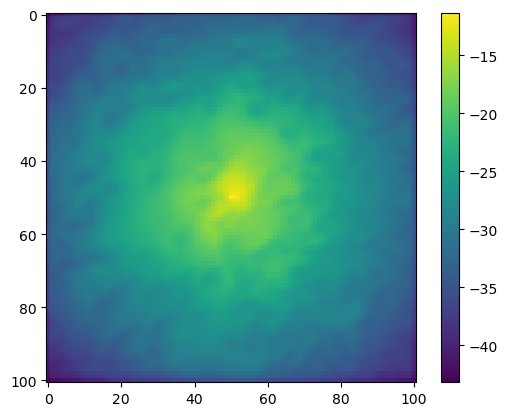

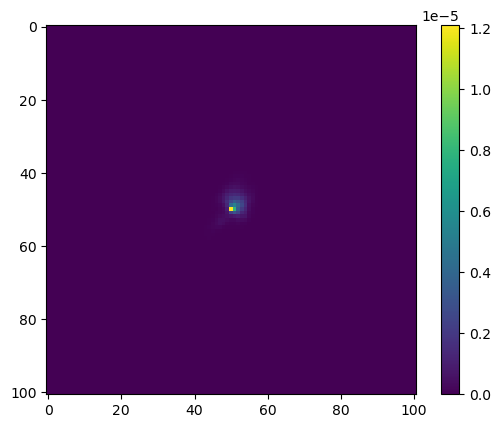

Sampled coordinates: (48, 47)
1198
1241
29950.0 -1437025.0
29950.0 -1437025.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


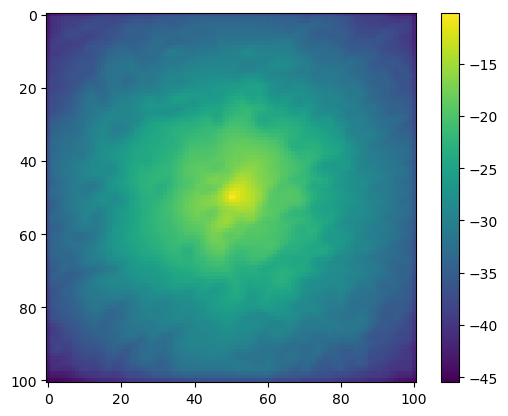

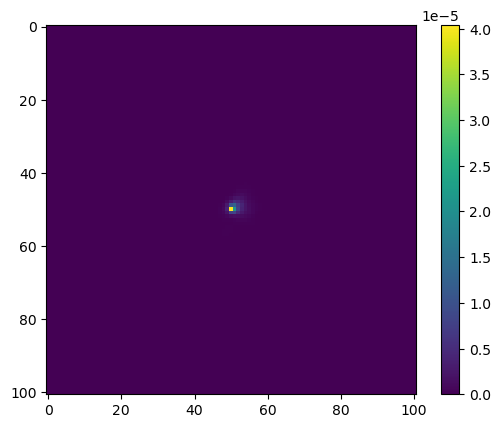

Sampled coordinates: (51, 49)
1199
1240
29975.0 -1437000.0
29975.0 -1437000.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


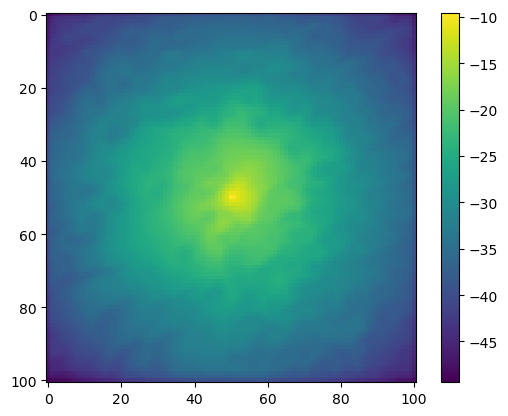

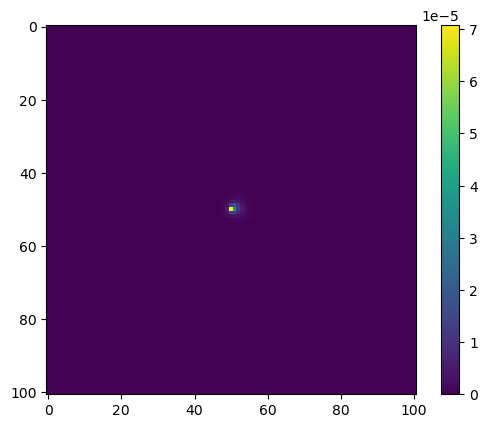

Sampled coordinates: (50, 48)
1199
1238
29975.0 -1436950.0
29975.0 -1436950.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


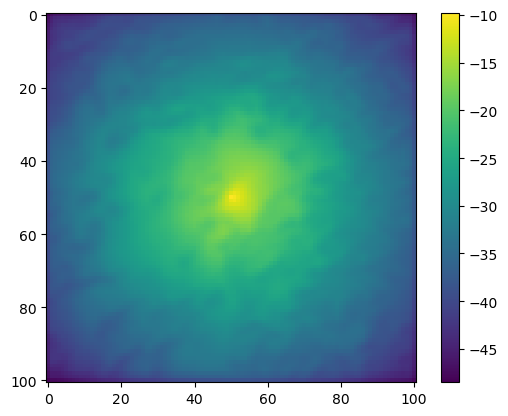

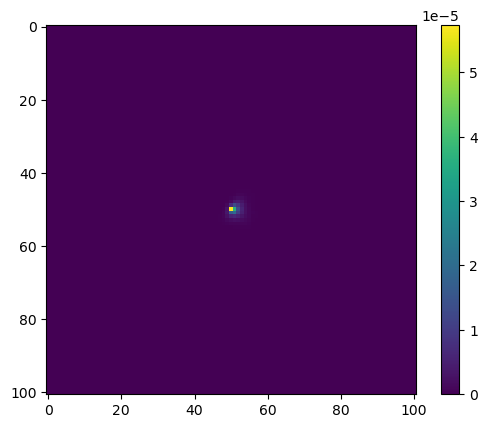

Sampled coordinates: (51, 54)
1200
1242
30000.0 -1437050.0
30000.0 -1437050.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


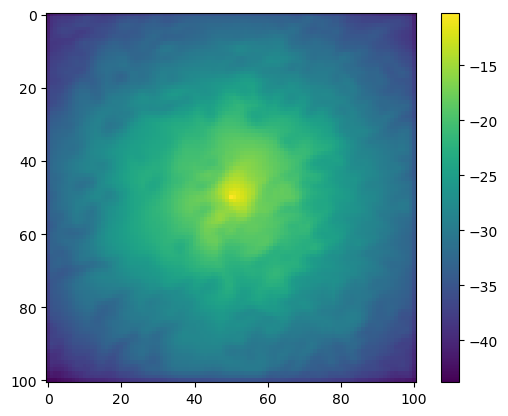

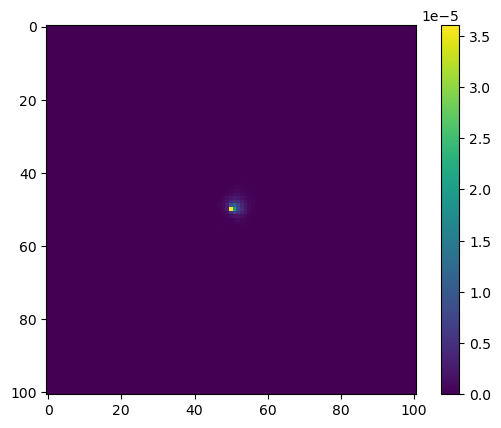

Sampled coordinates: (51, 52)
1201
1244
30025.0 -1437100.0
30025.0 -1437100.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


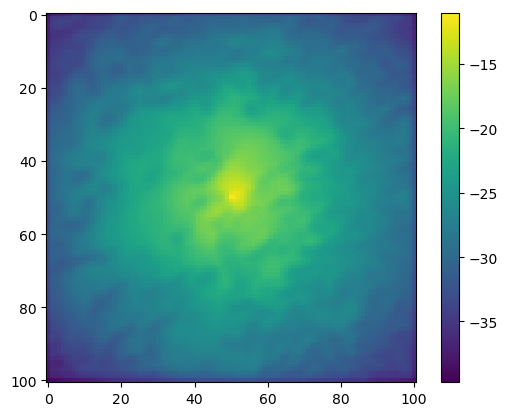

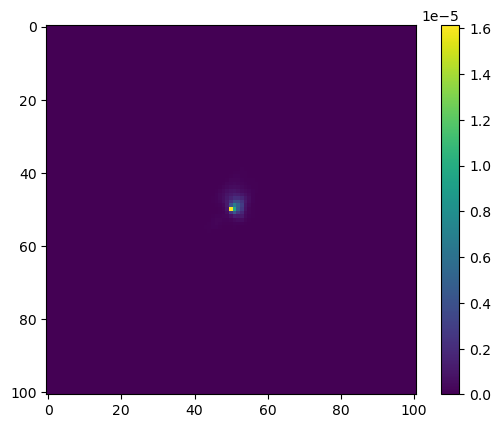

Sampled coordinates: (49, 51)
1200
1245
30000.0 -1437125.0
30000.0 -1437125.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


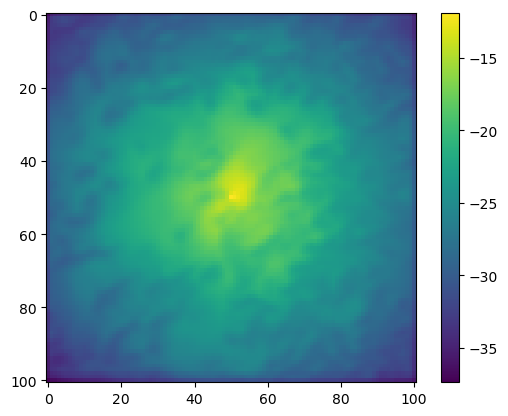

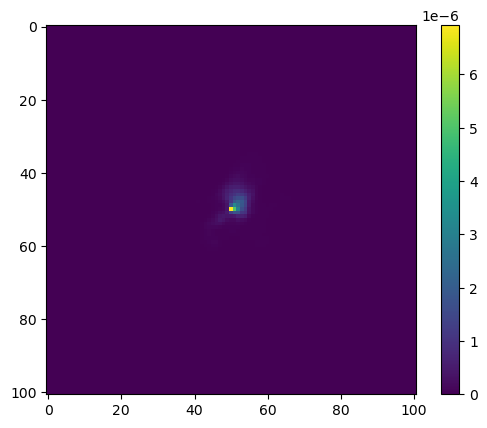

Sampled coordinates: (52, 49)
1202
1244
30050.0 -1437100.0
30050.0 -1437100.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


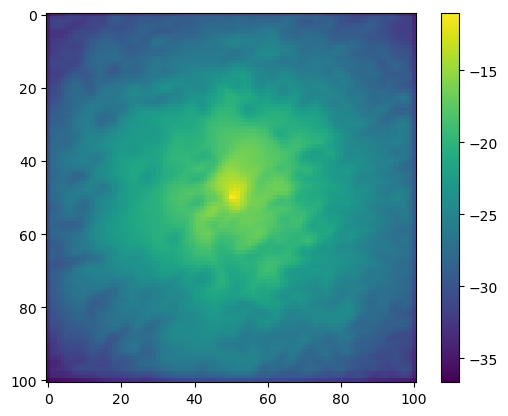

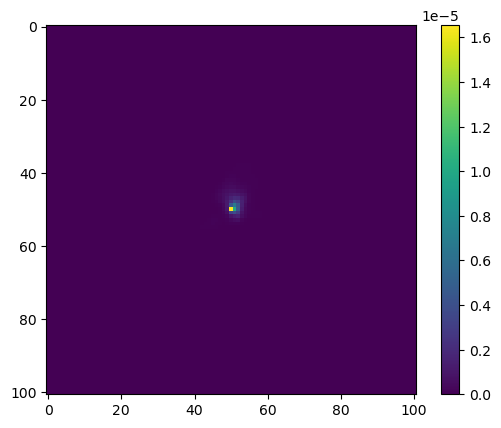

Sampled coordinates: (50, 50)
1202
1244
30050.0 -1437100.0
30050.0 -1437100.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


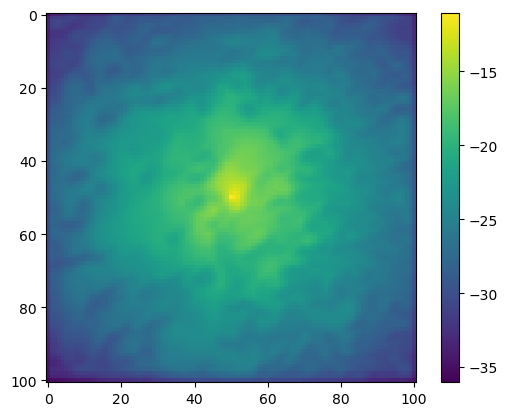

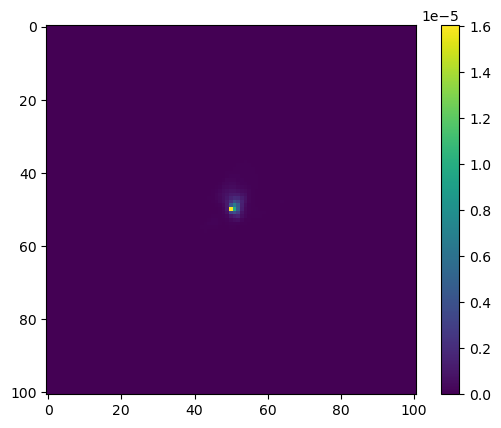

Sampled coordinates: (43, 49)
1195
1243
29875.0 -1437075.0
29875.0 -1437075.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


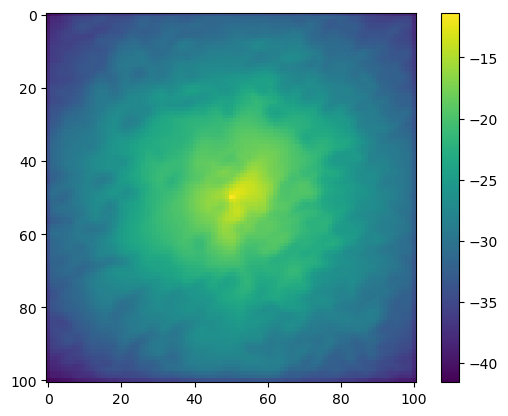

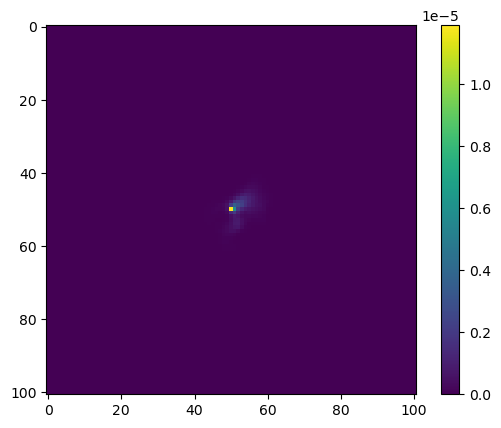

Sampled coordinates: (50, 53)
1195
1246
29875.0 -1437150.0
29875.0 -1437150.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


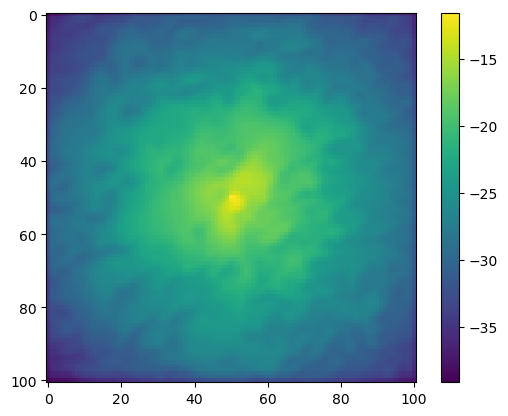

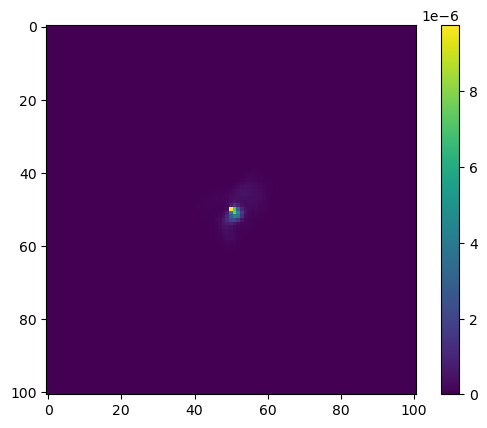

Sampled coordinates: (50, 50)
1195
1246
29875.0 -1437150.0
29875.0 -1437150.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


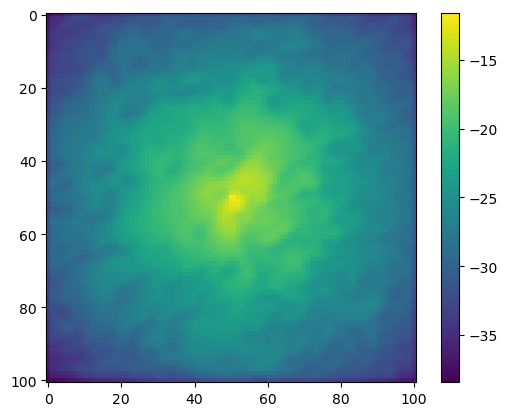

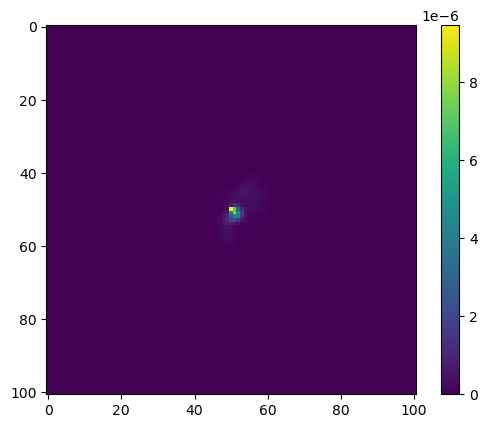

Sampled coordinates: (51, 51)
1196
1247
29900.0 -1437175.0
29900.0 -1437175.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


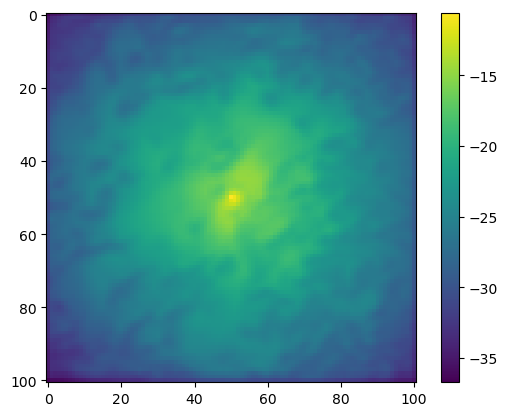

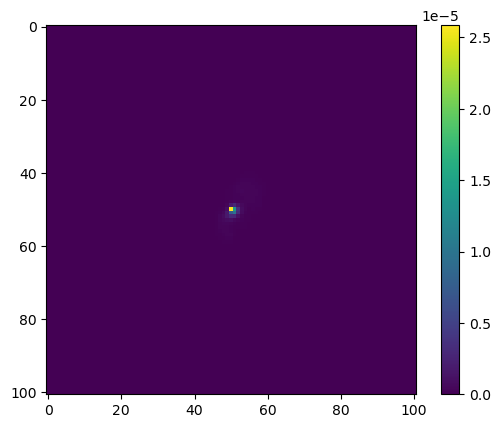

Sampled coordinates: (54, 56)
1200
1253
30000.0 -1437325.0
30000.0 -1437325.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


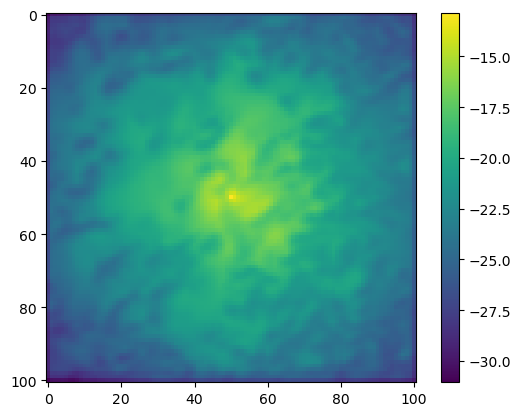

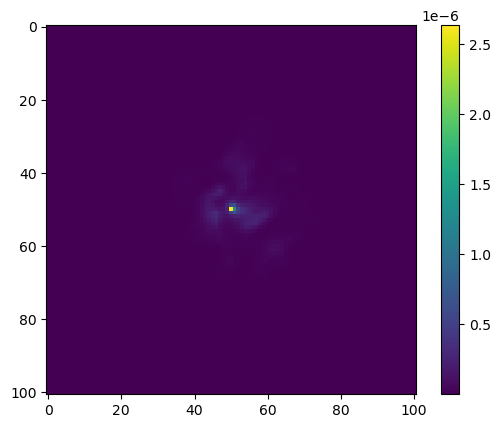

Sampled coordinates: (50, 46)
1200
1249
30000.0 -1437225.0
30000.0 -1437225.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


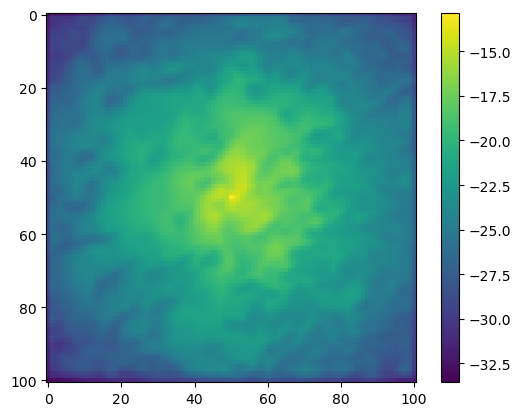

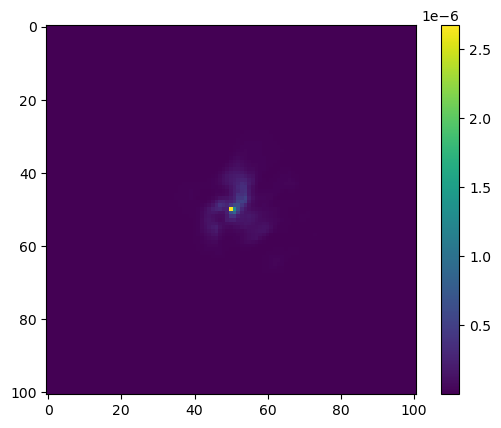

Sampled coordinates: (46, 54)
1196
1253
29900.0 -1437325.0
29900.0 -1437325.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


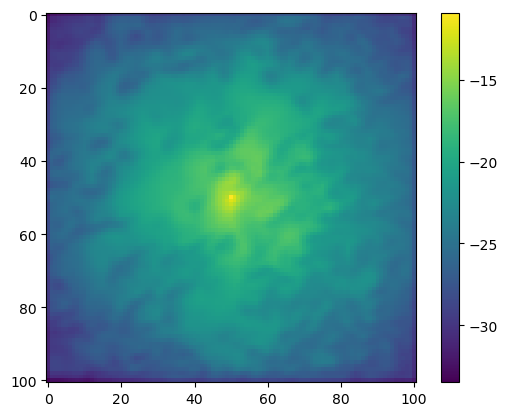

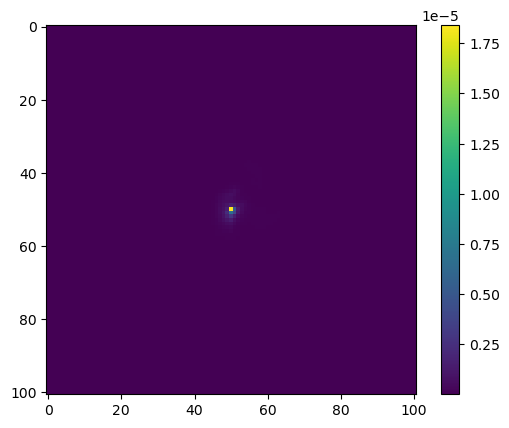

Sampled coordinates: (44, 50)
1190
1253
29750.0 -1437325.0
29750.0 -1437325.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


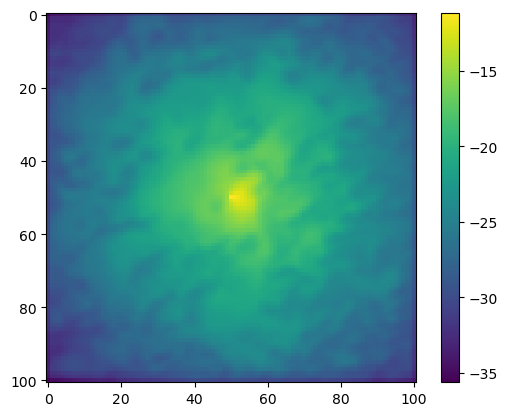

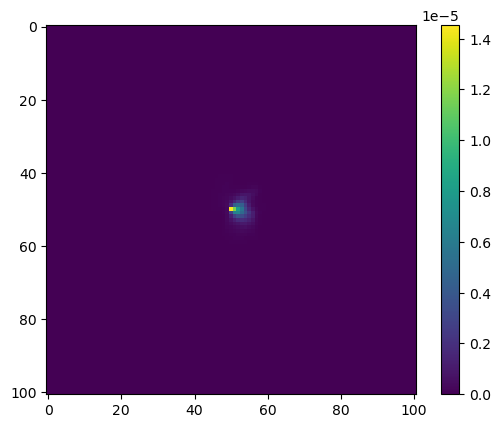

Sampled coordinates: (50, 54)
1190
1257
29750.0 -1437425.0
29750.0 -1437425.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


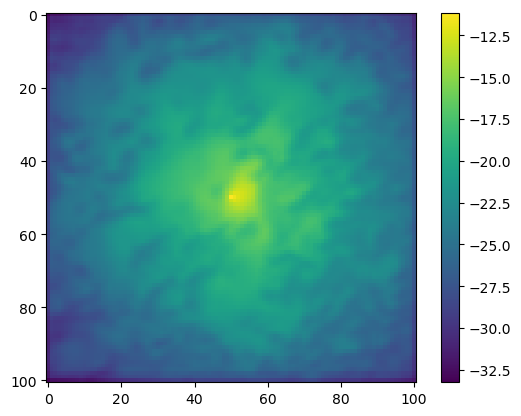

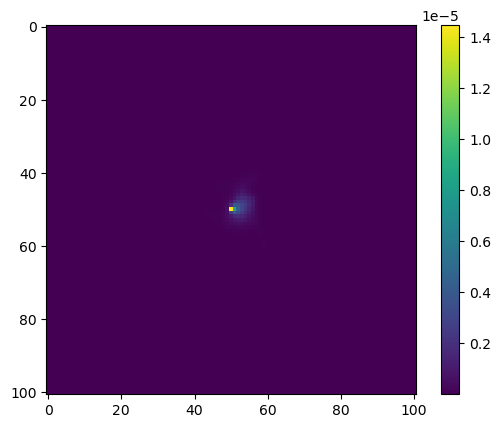

Sampled coordinates: (48, 56)
1188
1263
29700.0 -1437575.0
29700.0 -1437575.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


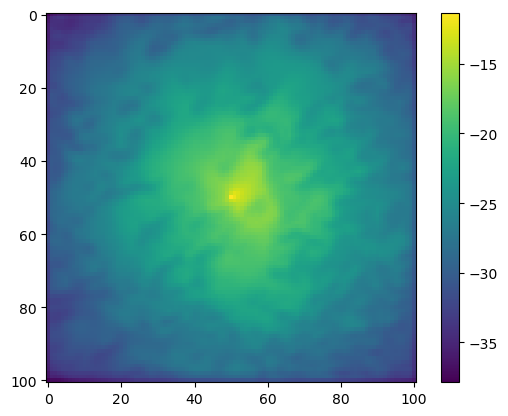

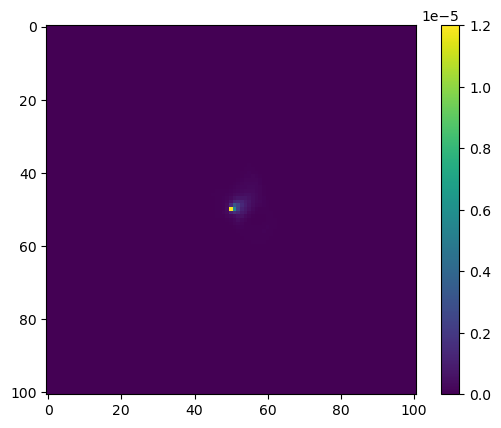

Sampled coordinates: (45, 43)
1183
1256
29575.0 -1437400.0
29575.0 -1437400.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


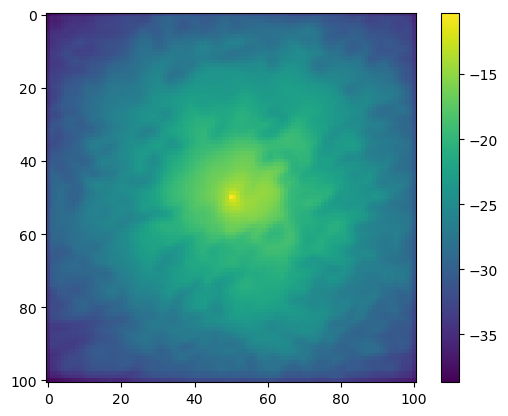

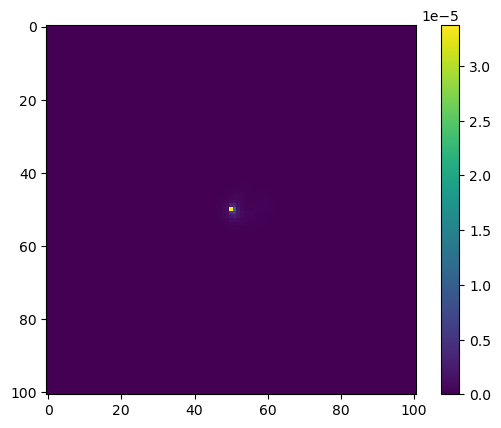

Sampled coordinates: (50, 50)
1183
1256
29575.0 -1437400.0
29575.0 -1437400.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


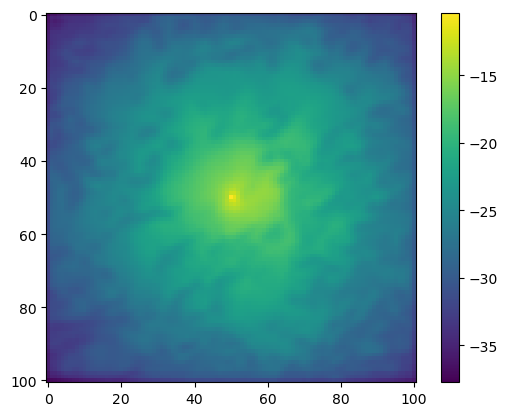

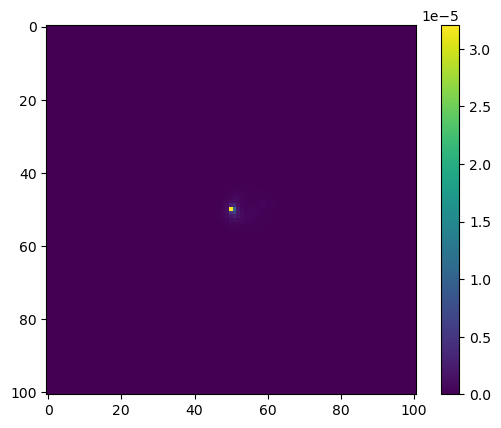

Sampled coordinates: (59, 44)
1192
1250
29800.0 -1437250.0
29800.0 -1437250.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


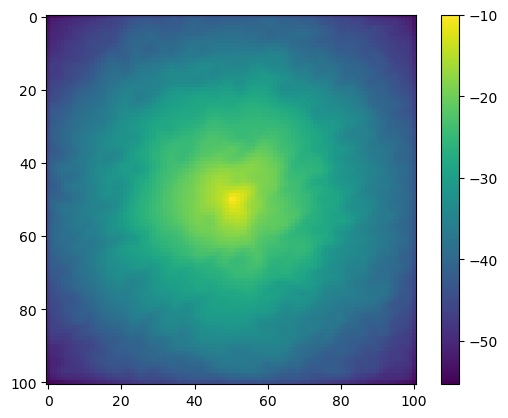

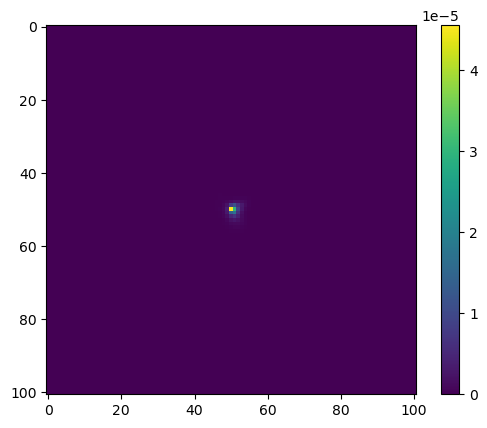

Sampled coordinates: (54, 52)
1196
1252
29900.0 -1437300.0
29900.0 -1437300.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


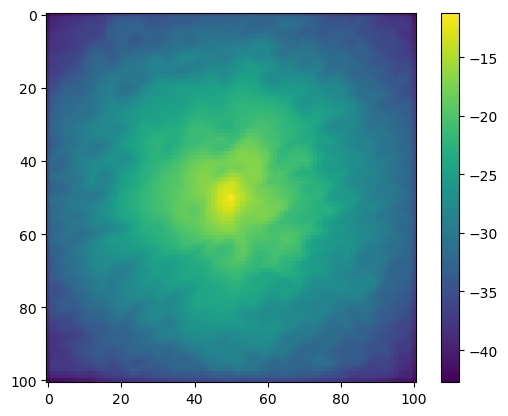

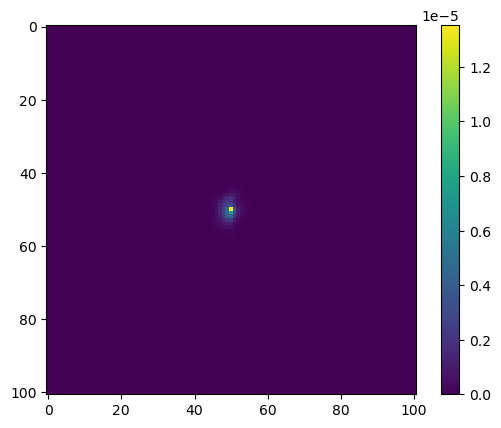

Sampled coordinates: (44, 49)
1190
1251
29750.0 -1437275.0
29750.0 -1437275.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


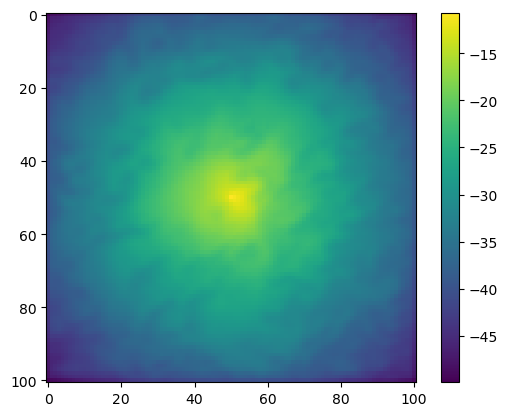

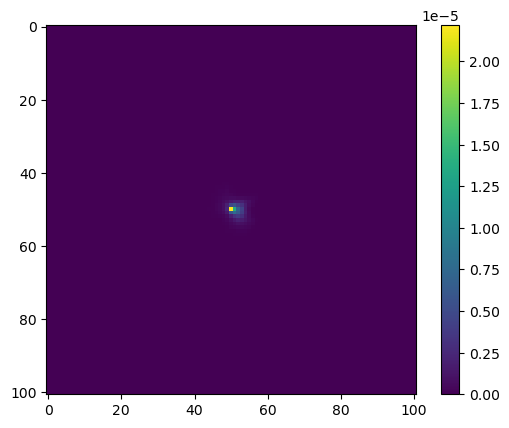

Sampled coordinates: (51, 51)
1191
1252
29775.0 -1437300.0
29775.0 -1437300.0
torch.Size([1, 4, 101, 101])
Shape before squeeze: torch.Size([1, 1, 101, 101])
Shape before logsumexp: torch.Size([1, 101, 101])
torch.Size([1, 101, 101, 2])
torch.Size([101, 101])


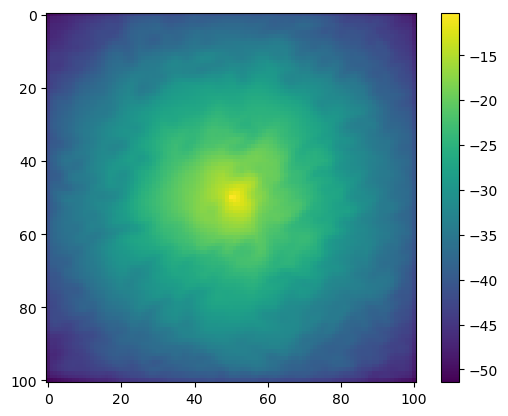

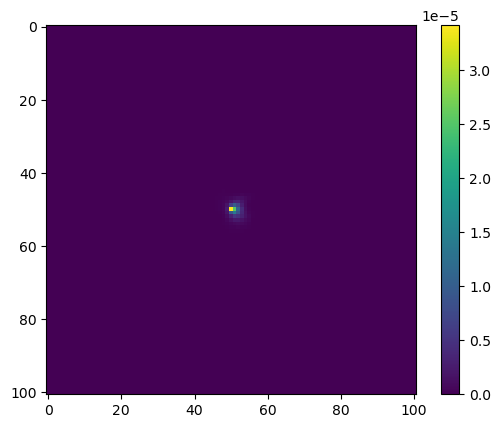

Sampled coordinates: (50, 52)
1191
1254
29775.0 -1437350.0
29775.0 -1437350.0


In [265]:
for i in range(1, n_steps):

    x_loc = x[i-1]
    y_loc = y[i-1]
    x2 = x2_full[i,:].unsqueeze(dim=0)
    
    new_x, new_y = simulate_trajectory(global_raster_tensors=global_raster_list,
                                       additional_data_tensor=x2,
                                       window_size=101,
                                       x_loc=x_loc,
                                       y_loc=y_loc,
                                       global_raster_transform=global_raster_transform)
    
    print(new_x, new_y)

    x[i] = new_x
    y[i] = new_y